## Install the package dependencies before running this notebook

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
from tqdm import tqdm
import pandas as pd

"""
    number of trajectories in each city 
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971 
    # pittsburgh -- train: 43544 test: 6361 
    # dearborn -- train: 24465 test: 3671 
    # washington-dc -- train: 25744 test: 3829 
    # palo-alto -- train:  11993 test:1686 

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city \n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971 \n    # pittsburgh -- train: 43544 test: 6361 \n    # dearborn -- train: 24465 test: 3671 \n    # washington-dc -- train: 25744 test: 3829 \n    # palo-alto -- train:  11993 test:1686 \n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [6]:
from glob import glob
import pickle5 as pickle
import numpy as np

ROOT_PATH = "./argo2/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    #f_in = ROOT_PATH + split + "/" + city + "_inputs"
    f_in = split + '/' + city + "_inputs"
    inputs = pickle.load(open(f_in, "rb"))
    inputs = np.asarray(inputs)
    
    outputs = None
    
    if split=="train":
        #f_out = ROOT_PATH + split + "/" + city + "_outputs"
        f_out = split + '/' + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

# intialize a dataset
city = 'palo-alto' 
split = 'train'
train_dataset  = ArgoverseDataset(city = city, split = split)

## Create a DataLoader class for training

In [7]:
batch_sz = 4  # batch size 
train_loader = DataLoader(train_dataset,batch_size=batch_sz)

## Sample a batch of data and visualize 

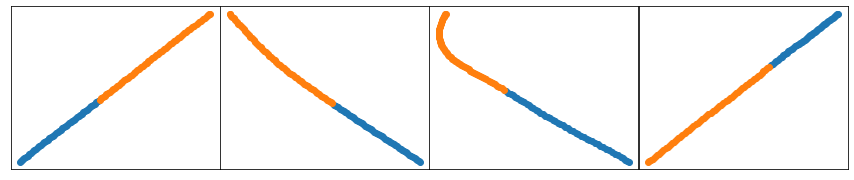

In [8]:
import matplotlib.pyplot as plt
import random


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])

        
for i_batch, sample_batch in enumerate(train_loader):
    inp, out = sample_batch
    """
    TODO:
      implement your Deep learning model
      implement training routine
    """
    show_sample_batch(sample_batch)
    
    break

In [9]:
train_city_datasets = [ArgoverseDataset(city, split = "train") for city in cities]
train_inp_datasets = []
train_out_datasets = []
for dataset in train_city_datasets:
    inp, out = dataset[:]
    train_inp_datasets.append(inp)
    train_out_datasets.append(out)

In [10]:
"""

from torch.autograd import Variable
import torch.nn.functional as F
from fastprogress import master_bar, progress_bar

def make_valid_set(train_inp, train_out, train_subset = 0.8):
    if len(train_inp) != len(train_out):
        raise ValueError("Input and output lengths should be the same!")
    n = len(train_inp)
    
    split = int(n * train_subset)
    new_train_inp = train_inp[:split]
    new_train_out = train_out[:split]
    valid_inp = train_inp[split:]
    valid_out = train_out[split:]
    
    return new_train_inp, new_train_out, valid_inp, valid_out

austin_trainX, austin_trainY, austin_valX, austin_valY = make_valid_set(train_inp_datasets[0], train_out_datasets[0])
"""
print(end = '')

In [11]:
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=2)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0])

        return out

In [12]:
import math
batch_size = 4
length = len(train_city_datasets[0])
temp = torch.utils.data.random_split(train_city_datasets[0], [math.floor(length*0.8), math.ceil(length*0.2)])
train_loader = DataLoader(temp[0], batch_size=batch_size)
val_loader = DataLoader(temp[1], batch_size=batch_size)

In [13]:
learning_rate = 5e-5
num_hidden_units = 16

model = ShallowRegressionLSTM(num_sensors=2, hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
"""
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    for X, y in train_loader:
        output = model(X.float())
        loss = loss_function(output, y.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X.float())
            total_loss += loss_function(output, y.float()).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")


print("Untrained test\n--------")
test_model(val_loader, model, loss_function)
print()

for ix_epoch in range(2):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(val_loader, model, loss_function)
    print()
"""
print('', end = '')

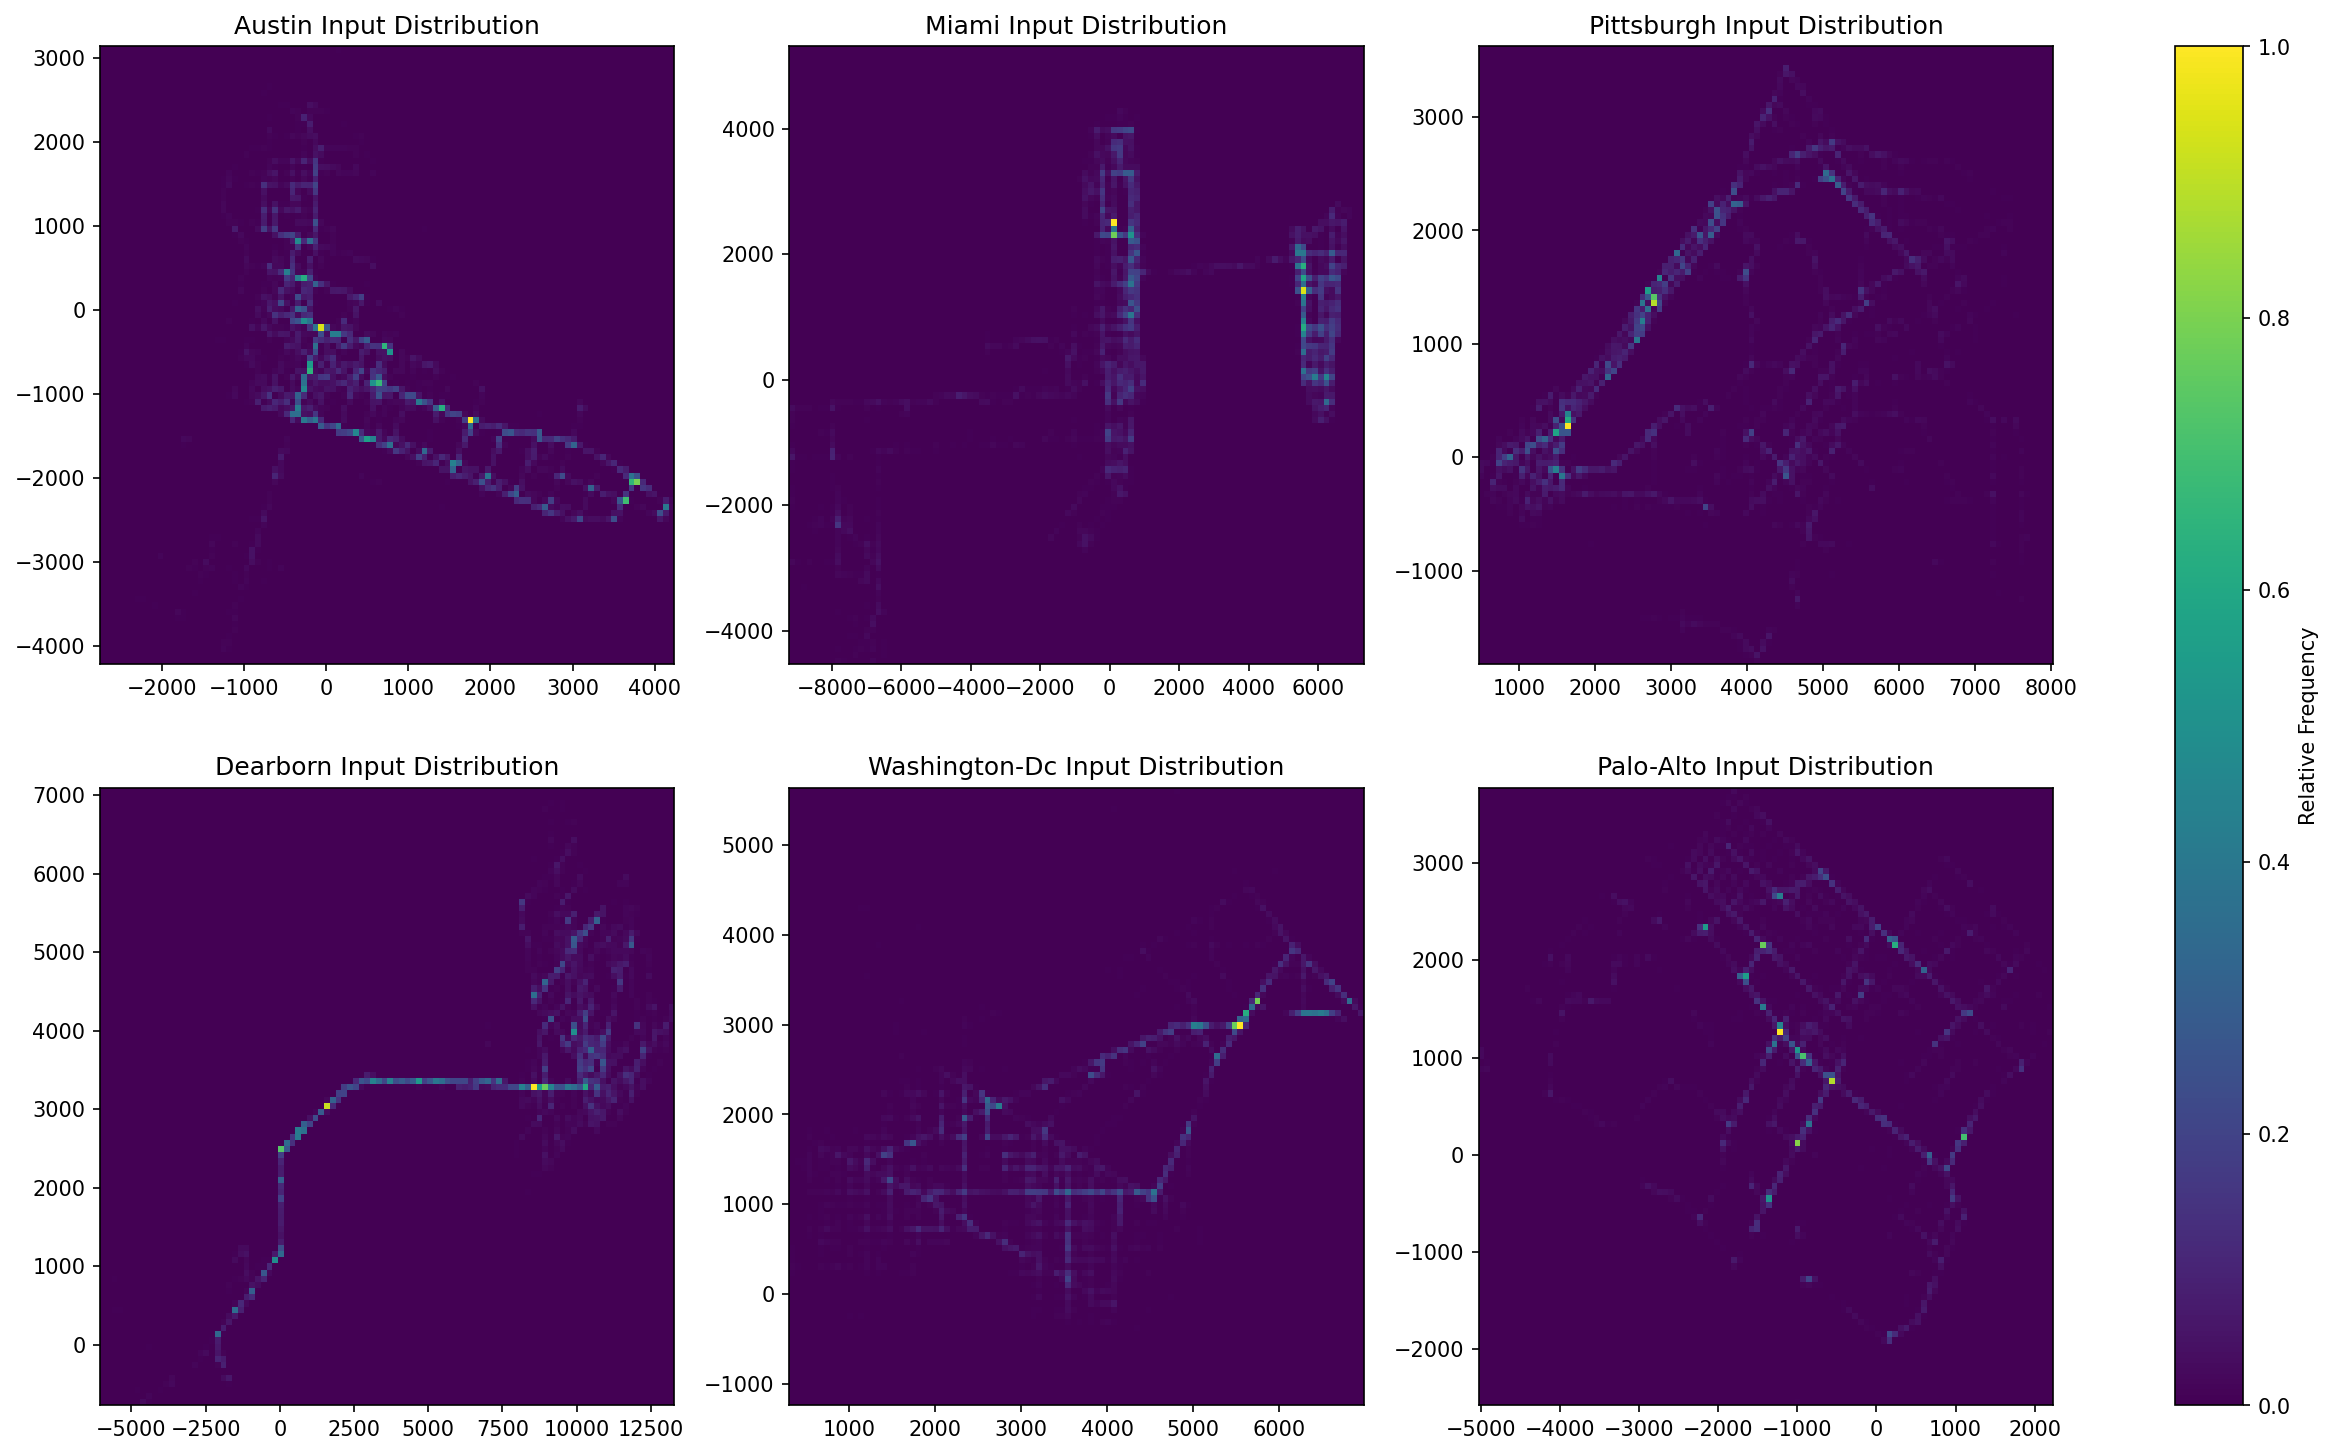

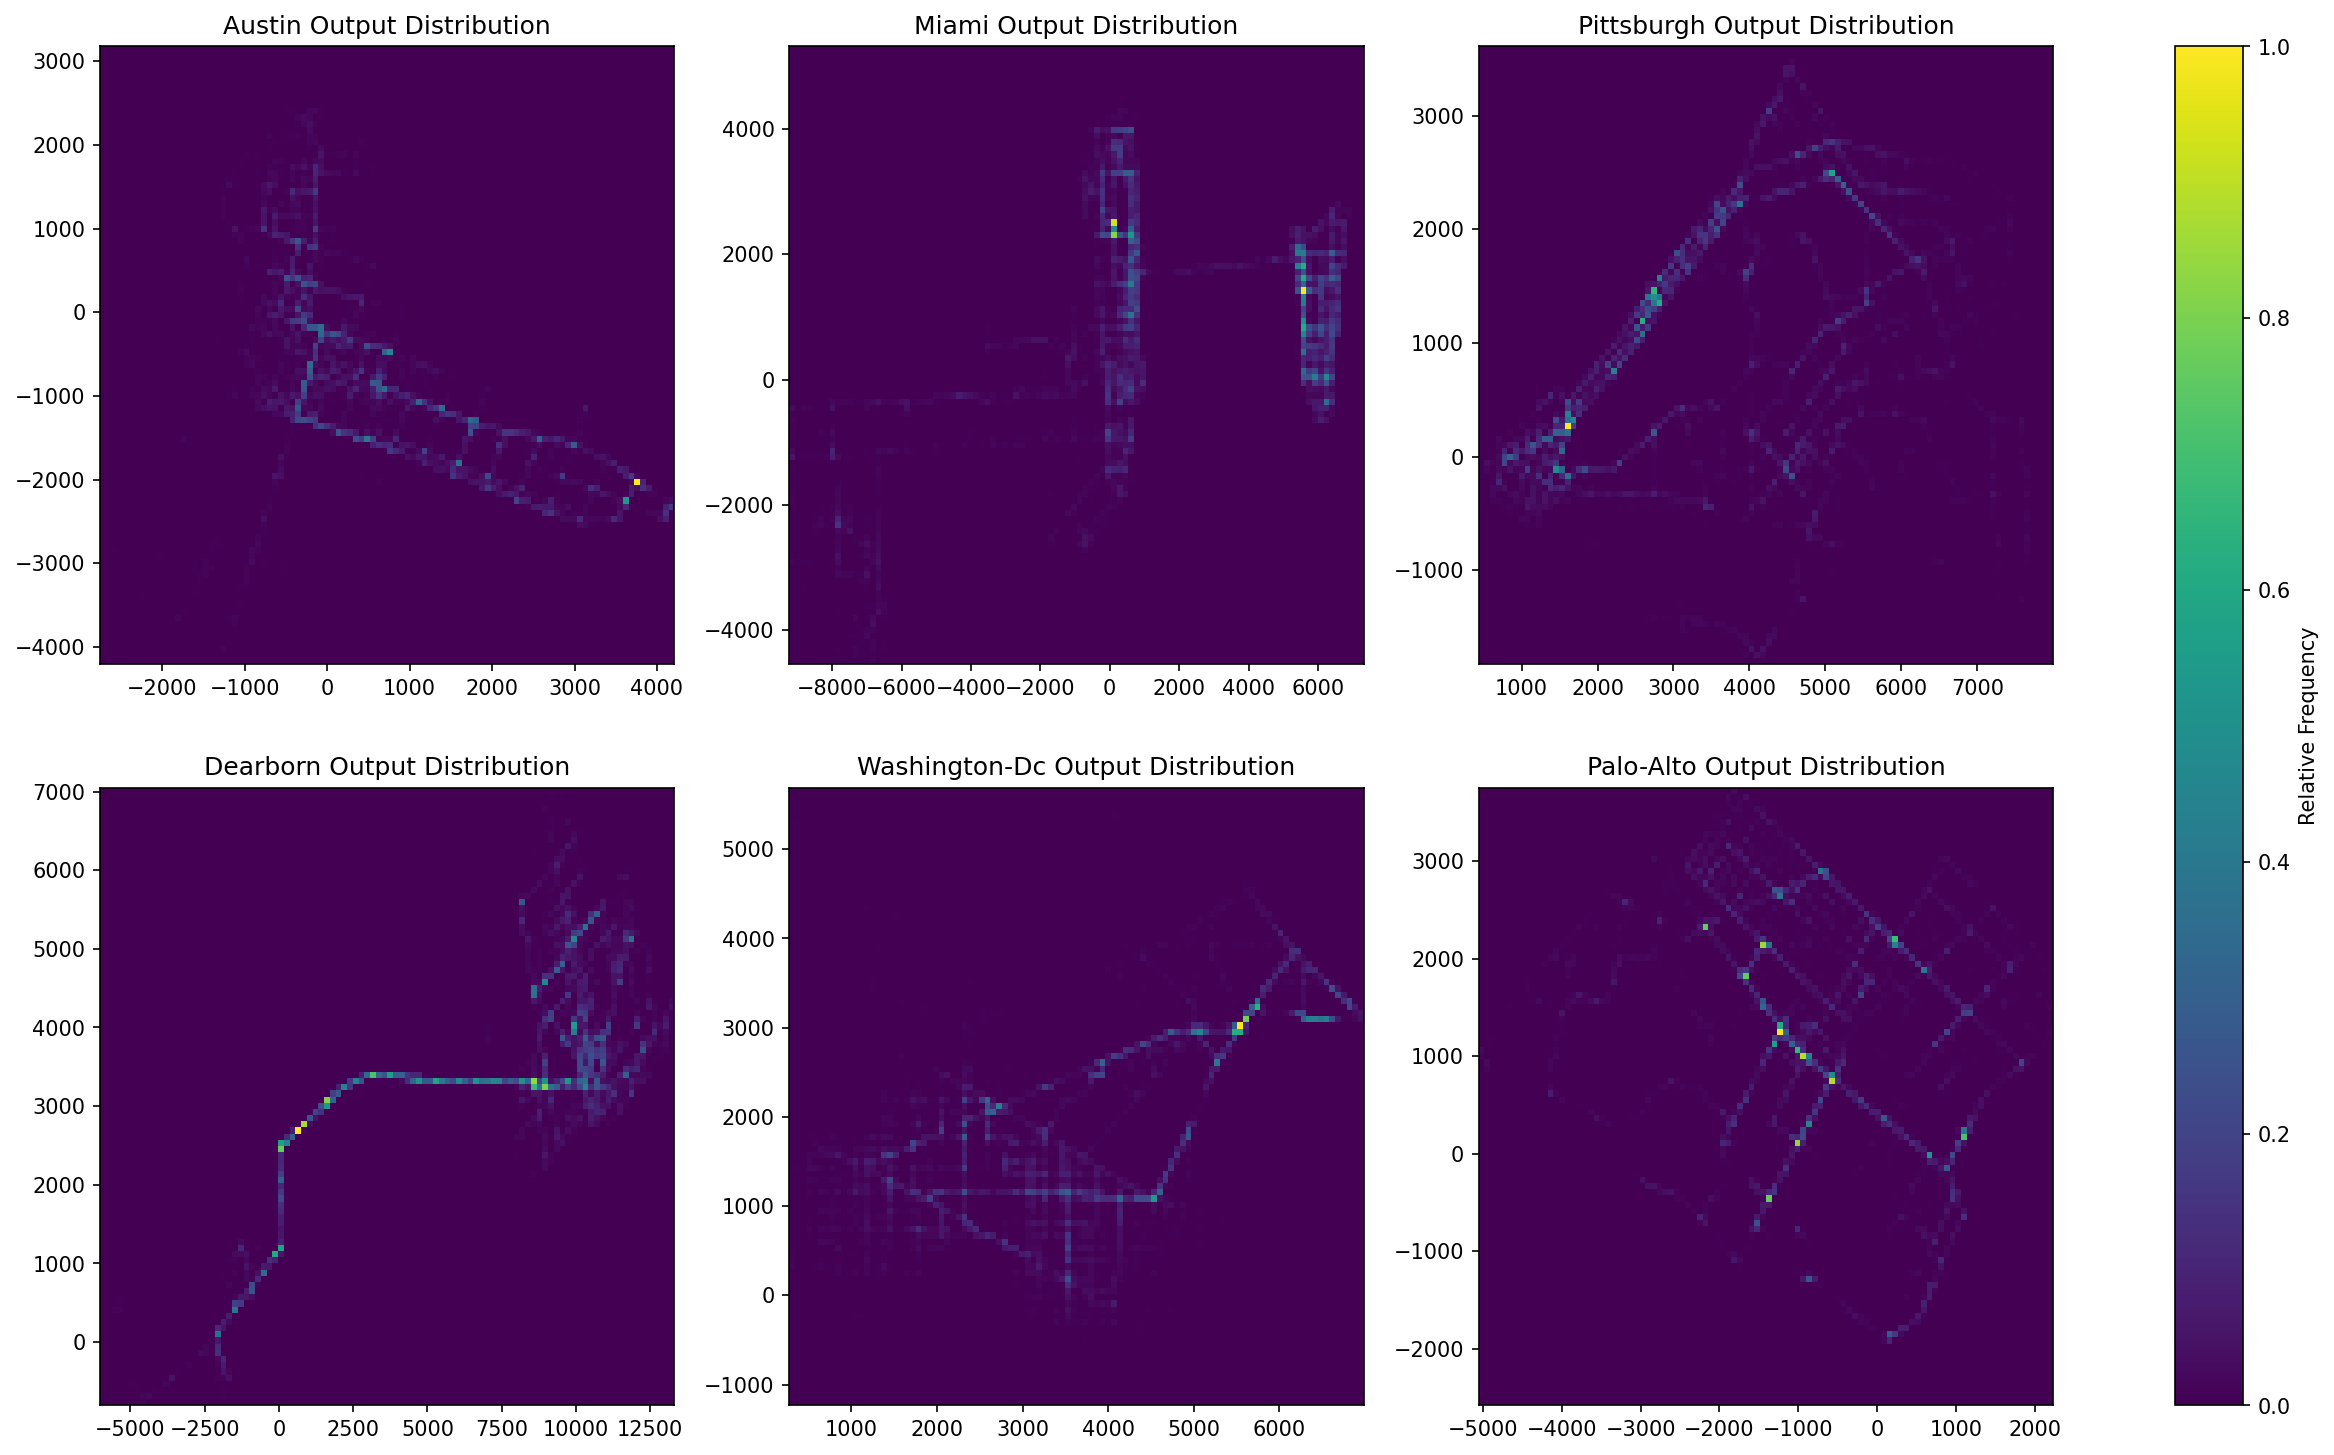

In [15]:
fig_inp, axs_inp = plt.subplots(2, int(len(cities)/2), figsize = (21, 12), dpi = 150, facecolor = "white")
fig_out, axs_out = plt.subplots(2, int(len(cities)/2), figsize = (21, 12), dpi = 150, facecolor = "white")

for i in range(len(cities)):
    city = cities[i]
    inp, out = train_inp_datasets[i], train_out_datasets[i]
    ax_inp = axs_inp.flatten()[i]
    ax_out = axs_out.flatten()[i]
    ax_inp.hist2d(inp[:,:,0].flatten(), inp[:,:,1].flatten(), bins = (100, 100))
    ax_out.hist2d(out[:,:,0].flatten(), out[:,:,1].flatten(), bins = (100, 100))
    ax_inp.set_title(city.title() + " Input Distribution")
    ax_out.set_title(city.title() + " Output Distribution")

cbar_inp = fig_inp.colorbar(mappable = ax_inp.pcolormesh([np.arange(0, 10 + 1)/10]), ax = axs_inp)
cbar_out = fig_out.colorbar(mappable = ax_out.pcolormesh([np.arange(0, 10 + 1)/10]), ax = axs_out)
cbar_inp.set_label("Relative Frequency")
cbar_out.set_label("Relative Frequency")

In [16]:
train_inp_all = np.concatenate(train_inp_datasets)
train_out_all = np.concatenate(train_out_datasets)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  """


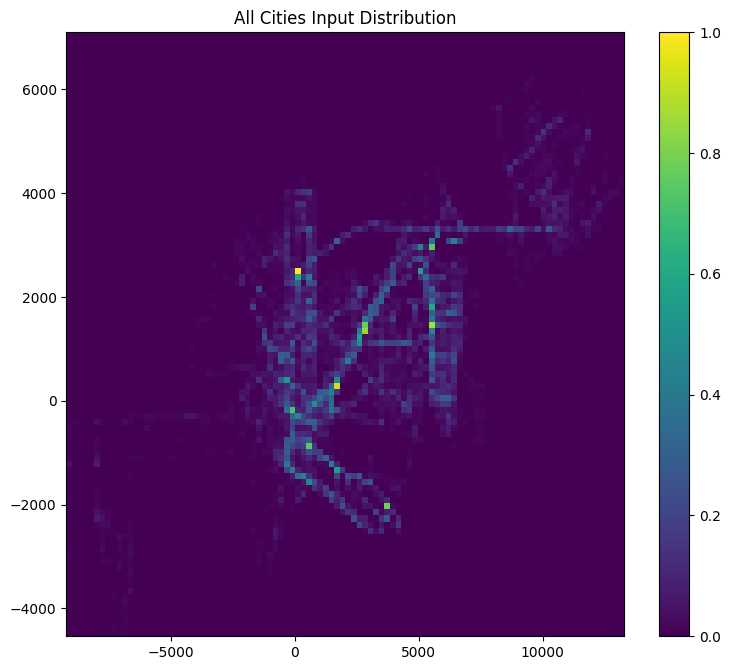

In [17]:
plt.figure(figsize = (9, 8), dpi = 100)

ax = plt.hist2d(train_inp_all[:,:,0].flatten(), train_inp_all[:,:,1].flatten(), bins = (100, 100))
plt.title("All Cities Input Distribution")
plt.colorbar(mappable = ax_out.pcolormesh([np.arange(0, 10 + 1)/10]));

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  """


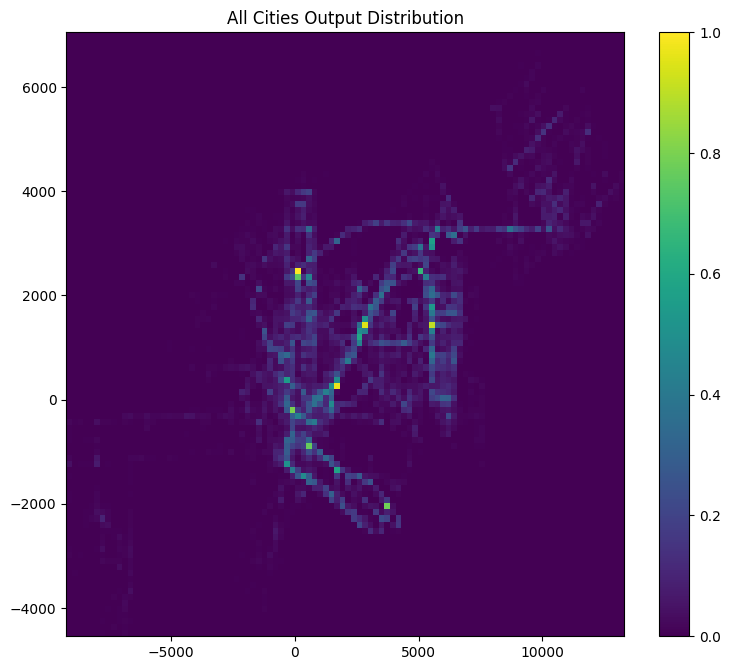

In [18]:
plt.figure(figsize = (9, 8), dpi = 100)

plt.hist2d(train_out_all[:,:,0].flatten(), train_out_all[:,:,1].flatten(), bins = (100, 100))
plt.title("All Cities Output Distribution")
plt.colorbar(mappable = ax_out.pcolormesh([np.arange(0, 10 + 1)/10]));

In [19]:
train_inp_all.shape

(203816, 50, 2)

In [20]:
train_out_all.shape

(203816, 60, 2)

In [21]:
test_city_datasets = [get_city_trajectories(city, split = "test")[0] for city in cities]
test_inp_all = np.concatenate(test_city_datasets)

In [22]:
test_inp_all.shape

(29843, 50, 2)

In [23]:
def make_valid_set(train_inp, train_out, train_subset = 0.8):
    if len(train_inp) != len(train_out):
        raise ValueError("Input and output lengths should be the same!")
    n = len(train_inp)
    
    split = int(n * train_subset)
    new_train_inp = train_inp[:split]
    new_train_out = train_out[:split]
    valid_inp = train_inp[split:]
    valid_out = train_out[split:]
    
    return (new_train_inp, new_train_out), (valid_inp, valid_out)

In [24]:
class LSTM(torch.nn.Module):
    """
    Implementation of a character based LSTM R-NN for the prediction task.
    """
    
    def __init__(self, train_inp, train_out, sequence_length = 1, hidden_size = 100):
        super(LSTM, self).__init__()
        self.train_input, self.train_output = train_inp, train_out
        self.train_input = torch.tensor(self.train_input).float()
        self.train_output = torch.tensor(self.train_output).float()
        if self.train_input.shape[1] % sequence_length == 0 and self.train_output.shape[1] % sequence_length == 0:
            self.sequence_length = sequence_length
        else:
            raise ValueError("Input and output lengths must be divisible by given sequence length!")
        
        input_size, output_size = self.train_input.shape[2], self.train_output.shape[2]
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers = 1)
        self.fc = torch.nn.Linear(hidden_size, output_size)
        
        
    def forward(self, input_tensor, hidden_state):
        if len(input_tensor.shape) == 2:
            input_tensor = input_tensor.unsqueeze(dim = 0)
        output, hidden_state = self.lstm(input_tensor, hidden_state)
        output = self.fc(output)
        return output, (hidden_state[0].detach(), hidden_state[1].detach())
    
    
    def predict(self, input_tensor, output_length = 60):
        if type(input_tensor) != torch.Tensor:
            input_tensor = torch.Tensor(input_tensor)
        input_tensor = input_tensor.float()
        total_output = []
        hidden_state = None
        
        for tensor in input_tensor:
            tensor_output = []
            input_coordinates = tensor[-self.sequence_length:]
            for i in range(int(output_length / self.sequence_length)):
                output, hidden_state = self(input_coordinates, hidden_state)
                tensor_output.append(output)
                
                input_coordinates = torch.clone(output).detach()
            total_output.append(torch.cat(tensor_output).unsqueeze(dim = 0))
            
        return torch.cat(total_output)
    
    
    def evaluate(self, pred, true):
        if type(pred) != torch.Tensor:
            pred = torch.tensor(pred)
        if type(true) != torch.Tensor:
            true = torch.tensor(true)
        pred = pred.float()
        true = true.float()
        
        MSE = torch.nn.MSELoss()
        loss = MSE(pred, true).item()
        
        return loss**(1/2)
    
    
    def train(self, learning_rate = 1e-3, num_epochs = 100, batch_size = 1.0, valid = None):
        n = len(self.train_input)
        if batch_size > 1.0:
            batch_n = batch_size
        elif batch_size < 0:
            raise ValueError("Batch size cannot be negative!")
        else:
            batch_n = int(n * batch_size)
        SSE = torch.nn.MSELoss(reduction = "sum")
        optimizer = torch.optim.Adam(self.parameters(), lr = learning_rate)
        train_loss = []
        
        if valid != None:
            valid_loss = []
            valid_inp, valid_out = valid
            old_loss = None
            new_loss = None
            bad_count = 0
        
        for epoch in tqdm(range(num_epochs)):
            epoch_SSE = 0
            np.random.seed(epoch)
            batch_idx = np.random.randint(n, size = batch_n)
            batch_inp = self.train_input[batch_idx]
            batch_out = self.train_output[batch_idx]
            
            for i in range(batch_n):
                input_tensor = batch_inp[i]
                input_coordinates = torch.unsqueeze(input_tensor[:self.sequence_length], dim = 0).float()
                output_tensor = batch_out[i]
                io_tensor = torch.cat([input_tensor, output_tensor])
                hidden_state = None

                use_output = False

                for j in range(int((len(io_tensor) - 1) / self.sequence_length)):
                    target_coordinates = torch.unsqueeze(io_tensor[(j + 1) * self.sequence_length : (j + 2) * self.sequence_length], dim = 0)

                    output, hidden_state = self(input_coordinates, hidden_state)

                    loss = SSE(output, target_coordinates)
                    epoch_SSE += loss.item()

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    input_coordinates = torch.clone(output).detach()
            epoch_MSE = epoch_SSE / batch_n
            epoch_RMSE = epoch_MSE**(1/2)
            train_loss.append(epoch_RMSE)
            
            if valid != None:
                valid_pred = self.predict(valid_inp)
                valid_RMSE = self.evaluate(valid_pred, valid_out)
                valid_loss.append(valid_RMSE)
                new_loss = valid_RMSE
                if old_loss != None:
                    if new_loss >= old_loss:
                        bad_count += 1
                        if bad_count >= 3:
                            print("Early stopped after epoch ", epoch)
                            break
                    else:
                        bad_count = 0
                old_loss = new_loss
        
        if valid != None:
            return train_loss, valid_loss
        else:
            return train_loss


In [25]:
train_inp_all_subset, train_out_all_subset = train_inp_all[:int(len(train_inp_all) / 100)], train_out_all[:int(len(train_out_all) / 100)]

In [26]:
len(train_inp_all_subset)

2038

In [27]:
len(train_inp_all_subset) == len(train_out_all_subset)

True

In [28]:
train_all, valid_all = make_valid_set(train_inp_all_subset, train_out_all_subset)

In [29]:
X_train_all, y_train_all = train_all
X_valid_all, y_valid_all = valid_all

In [30]:
LSTM1 = LSTM(X_train_all, y_train_all, sequence_length = 1, hidden_size = 100)

In [31]:
#LSTM1_train_loss, LSTM1_valid_loss = LSTM1.train(batch_size = 0.25, valid = valid_all)

In [32]:
#LSTM1_train_pred = LSTM1.predict(X_train_all)
#LSTM1_valid_pred = LSTM1.predict(X_valid_all)

In [33]:
#LSTM1_train_RMSE = LSTM1.evaluate(LSTM1_train_pred, y_train_all)
#LSTM1_valid_RMSE = LSTM1.evaluate(LSTM1_valid_pred, y_valid_all)

In [34]:
#LSTM1_train_RMSE

In [35]:
#LSTM1_valid_RMSE

In [36]:
#torch.save(LSTM1.state_dict(), "saved_models/subset/LSTM1.pth")

In [37]:
#pd.DataFrame([LSTM1_train_loss, LSTM1_valid_loss]).T.rename(columns = {0: "train_loss", 1: "valid_loss"}).to_csv("saved_loss/subset/LSTM1.csv")

In [38]:
#LSTM2 = LSTM(X_train_all, y_train_all, sequence_length = 2, hidden_size = 100)

In [39]:
#LSTM2_train_loss, LSTM2_valid_loss = LSTM2.train(batch_size = 0.25, valid = valid_all)

In [40]:
#LSTM2_train_pred = LSTM2.predict(X_train_all)
#LSTM2_valid_pred = LSTM2.predict(X_valid_all)

In [41]:
#LSTM2_train_RMSE = LSTM2.evaluate(LSTM2_train_pred, y_train_all)
#LSTM2_valid_RMSE = LSTM2.evaluate(LSTM2_valid_pred, y_valid_all)

In [42]:
#LSTM2_train_RMSE

In [43]:
#LSTM2_valid_RMSE

In [44]:
#torch.save(LSTM2.state_dict(), "saved_models/subset/LSTM2.pth")

In [45]:
#pd.DataFrame([LSTM2_train_loss, LSTM2_valid_loss]).T.rename(columns = {0: "train_loss", 1: "valid_loss"}).to_csv("saved_loss/subset/LSTM2.csv")

In [46]:
#LSTM5 = LSTM(X_train_all, y_train_all, sequence_length = 5, hidden_size = 100)

In [47]:
#LSTM5_train_loss, LSTM5_valid_loss = LSTM5.train(batch_size = 0.25, valid = valid_all)

In [48]:
#LSTM5_train_pred = LSTM5.predict(X_train_all)
#LSTM5_valid_pred = LSTM5.predict(X_valid_all)

In [49]:
#LSTM5_train_RMSE = LSTM5.evaluate(LSTM5_train_pred, y_train_all)
#LSTM5_valid_RMSE = LSTM5.evaluate(LSTM5_valid_pred, y_valid_all)

In [50]:
#LSTM5_train_RMSE

In [51]:
#LSTM5_valid_RMSE

In [52]:
#torch.save(LSTM5.state_dict(), "saved_models/subset/LSTM5.pth")

In [53]:
#pd.DataFrame([LSTM5_train_loss, LSTM5_valid_loss]).T.rename(columns = {0: "train_loss", 1: "valid_loss"}).to_csv("saved_loss/subset/LSTM5.csv")

In [54]:
#LSTM10 = LSTM(X_train_all, y_train_all, sequence_length = 10, hidden_size = 100)

In [55]:
#LSTM10_train_loss, LSTM10_valid_loss = LSTM10.train(batch_size = 0.25, valid = valid_all)

In [56]:
#LSTM10_train_pred = LSTM10.predict(X_train_all)
#LSTM10_valid_pred = LSTM10.predict(X_valid_all)

In [57]:
#LSTM10_train_RMSE = LSTM10.evaluate(LSTM10_train_pred, y_train_all)
#LSTM10_valid_RMSE = LSTM10.evaluate(LSTM10_valid_pred, y_valid_all)

In [58]:
#LSTM10_train_RMSE

In [59]:
#LSTM10_valid_RMSE

In [60]:
#torch.save(LSTM5.state_dict(), "saved_models/subset/LSTM10.pth")

In [61]:
#pd.DataFrame([LSTM10_train_loss, LSTM10_valid_loss]).T.rename(columns = {0: "train_loss", 1: "valid_loss"}).to_csv("saved_loss/subset/LSTM10.csv")

In [62]:
"""
plt.figure(figsize = (8, 8), dpi = 100)

plt.plot(LSTM1_train_loss, marker = 'o')
plt.title("LSTM Training Loss (Sequence Length 1)")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid()
"""
print('', end = '')

In [63]:
"""
plt.figure(figsize = (8, 8), dpi = 100)

plt.plot(LSTM2_train_loss, marker = 'o')
plt.title("LSTM Training Loss (Sequence Length 2)")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid()
"""
print('', end = '')

In [64]:
"""
plt.figure(figsize = (8, 8), dpi = 100)

plt.plot(LSTM5_train_loss, marker = 'o')
plt.title("LSTM Training Loss (Sequence Length 5)")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid()
"""
print('', end = '')

In [65]:
"""
plt.figure(figsize = (8, 8), dpi = 100)

plt.plot(LSTM10_train_loss, marker = 'o')
plt.title("LSTM Training Loss (Sequence Length 10)")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid()
"""
print('', end = '')

In [66]:
"""
plt.figure(figsize = (8, 8), dpi = 100)

plt.scatter(y_train_all[:50,:,0], y_train_all[:50,:,1], edgecolor = "black", linewidth = 0.1, label = "True")
plt.scatter(LSTM1_train_pred[:50,:,0].detach(), LSTM1_train_pred[:50,:,1].detach(), edgecolor = "black", linewidth = 0.1, label = "Predicted")
plt.legend()
plt.title("True vs. Predicted Values for LSTM with Sequence Length 1")
plt.xlabel("x Position")
plt.ylabel("y Position")
plt.grid()
"""
print('', end = '')

In [67]:
"""
plt.figure(figsize = (8, 8), dpi = 100)

plt.scatter(y_train_all[:50,:,0], y_train_all[:50,:,1], edgecolor = "black", linewidth = 0.1, label = "True")
plt.scatter(LSTM2_train_pred[:50,:,0].detach(), LSTM2_train_pred[:50,:,1].detach(), edgecolor = "black", linewidth = 0.1, label = "Predicted")
plt.legend()
plt.title("True vs. Predicted Values for LSTM with Sequence Length 2")
plt.xlabel("x Position")
plt.ylabel("y Position")
plt.grid()
"""
print('', end = '')

In [68]:
"""
plt.figure(figsize = (8, 8), dpi = 100)

plt.scatter(y_train_all[:50,:,0], y_train_all[:50,:,1], edgecolor = "black", linewidth = 0.1, label = "True")
plt.scatter(LSTM5_train_pred[:50,:,0].detach(), LSTM5_train_pred[:50,:,1].detach(), edgecolor = "black", linewidth = 0.1, label = "Predicted")
plt.legend()
plt.title("True vs. Predicted Values for LSTM with Sequence Length 5")
plt.xlabel("x Position")
plt.ylabel("y Position")
plt.grid()
"""
print('', end = '')

In [69]:
"""
plt.figure(figsize = (8, 8), dpi = 100)

plt.scatter(y_train_all[:50,:,0], y_train_all[:50,:,1], edgecolor = "black", linewidth = 0.1, label = "True")
plt.scatter(LSTM10_train_pred[:50,:,0].detach(), LSTM5_train_pred[:50,:,1].detach(), edgecolor = "black", linewidth = 0.1, label = "Predicted")
plt.legend()
plt.title("True vs. Predicted Values for LSTM with Sequence Length 10")
plt.xlabel("x Position")
plt.ylabel("y Position")
plt.grid()
"""
print('', end = '')

In [70]:
#pd.DataFrame(
#    [LSTM1_train_loss, LSTM2_train_loss, LSTM5_train_loss, LSTM10_train_loss]
#).T.rename(columns = {0: 1, 1: 2, 2: 5, 3: 10})

In [71]:
"""
pd.DataFrame(
    [LSTM1_train_RMSE, LSTM2_train_RMSE, LSTM5_train_RMSE, LSTM10_train_RMSE],
    index = [1, 2, 5, 10],
    columns = ["Final Train RMSE"]
)
"""
print('', end = '')

In [72]:
train_austin = train_city_datasets[0][:]
train_inp_austin, train_out_austin = train_austin

train_miami = train_city_datasets[1][:]
train_inp_miami, train_out_miami = train_miami

train_pittsburgh = train_city_datasets[2][:]
train_inp_pittsburgh, train_out_pittsburgh = train_pittsburgh

train_dearborn = train_city_datasets[3][:]
train_inp_dearborn, train_out_dearborn = train_dearborn

train_dc = train_city_datasets[4][:]
train_inp_dc, train_out_dc = train_dc

train_palo_alto = train_city_datasets[5][:]
train_inp_palo_alto, train_out_palo_alto = train_palo_alto

In [73]:
train_inp_austin_subset = train_inp_austin[:int(len(train_inp_austin) / 25)]
train_out_austin_subset = train_out_austin[:int(len(train_out_austin) / 25)]

train_inp_miami_subset = train_inp_miami[:int(len(train_inp_miami) / 25)]
train_out_miami_subset = train_out_miami[:int(len(train_out_miami) / 25)]

train_inp_pittsburgh_subset = train_inp_pittsburgh[:int(len(train_inp_pittsburgh) / 25)]
train_out_pittsburgh_subset = train_out_pittsburgh[:int(len(train_out_pittsburgh) / 25)]

train_inp_dearborn_subset = train_inp_dearborn[:int(len(train_inp_dearborn) / 15)]
train_out_dearborn_subset = train_out_dearborn[:int(len(train_out_dearborn) / 15)]

train_inp_dc_subset = train_inp_dc[:int(len(train_inp_dc) / 15)]
train_out_dc_subset = train_out_dc[:int(len(train_out_dc) / 15)]

train_inp_palo_alto_subset = train_inp_palo_alto[:int(len(train_inp_palo_alto) / 5)]
train_out_palo_alto_subset = train_out_palo_alto[:int(len(train_out_palo_alto) / 5)]

In [74]:
len(train_inp_austin_subset), len(train_inp_austin_subset) == len(train_out_austin_subset)

(1721, True)

In [75]:
len(train_inp_miami_subset), len(train_inp_miami_subset) == len(train_out_miami_subset)

(2201, True)

In [76]:
len(train_inp_pittsburgh_subset), len(train_inp_pittsburgh_subset) == len(train_out_pittsburgh_subset)

(1741, True)

In [77]:
len(train_inp_dearborn_subset), len(train_inp_dearborn_subset) == len(train_out_dearborn_subset)

(1631, True)

In [78]:
len(train_inp_dc_subset), len(train_inp_dc_subset) == len(train_out_dc_subset)

(1716, True)

In [79]:
len(train_inp_palo_alto_subset), len(train_inp_palo_alto_subset) == len(train_out_palo_alto_subset)

(2398, True)

In [80]:
new_train_austin, valid_austin = make_valid_set(train_inp_austin_subset, train_out_austin_subset)
X_train_austin, y_train_austin = new_train_austin
X_valid_austin, y_valid_austin = valid_austin

In [81]:
new_train_miami, valid_miami = make_valid_set(train_inp_miami_subset, train_out_miami_subset)
X_train_miami, y_train_miami = new_train_miami
X_valid_miami, y_valid_miami = valid_miami

In [82]:
new_train_pittsburgh, valid_pittsburgh = make_valid_set(train_inp_pittsburgh_subset, train_out_pittsburgh_subset)
X_train_pittsburgh, y_train_pittsburgh = new_train_pittsburgh
X_valid_pittsburgh, y_valid_pittsburgh = valid_miami

In [83]:
new_train_dearborn, valid_dearborn = make_valid_set(train_inp_dearborn_subset, train_out_dearborn_subset)
X_train_dearborn, y_train_dearborn = new_train_dearborn
X_valid_dearborn, y_valid_dearborn = valid_dearborn

In [84]:
new_train_dc, valid_dc = make_valid_set(train_inp_dc_subset, train_out_dc_subset)
X_train_dc, y_train_dc = new_train_dc
X_valid_dc, y_valid_dc = valid_dc

In [85]:
new_train_palo_alto, valid_palo_alto = make_valid_set(train_inp_palo_alto_subset, train_out_palo_alto_subset)
X_train_palo_alto, y_train_palo_alto = new_train_palo_alto
X_valid_palo_alto, y_valid_palo_alto = valid_palo_alto

In [86]:
LSTM_Austin = LSTM(X_train_austin, y_train_austin, sequence_length = 5, hidden_size = 100)
LSTM_Miami = LSTM(X_train_miami, y_train_miami, sequence_length = 5, hidden_size = 100)
LSTM_Pittsburgh = LSTM(X_train_pittsburgh, y_train_pittsburgh, sequence_length = 5, hidden_size = 100)
LSTM_Dearborn = LSTM(X_train_dearborn, y_train_dearborn, sequence_length = 5, hidden_size = 100)
LSTM_DC = LSTM(X_train_dc, y_train_dc, sequence_length = 5, hidden_size = 100)
LSTM_Palo_Alto = LSTM(X_train_palo_alto, y_train_palo_alto, sequence_length = 5, hidden_size = 100)

In [87]:
#LSTM_Austin_train_loss, LSTM_Austin_valid_loss = LSTM_Austin.train(batch_size = 0.25, valid = valid_austin)

In [88]:
#y_train_austin_pred = LSTM_Austin.predict(X_train_austin)
#y_valid_austin_pred = LSTM_Austin.predict(X_valid_austin)

In [89]:
#y_train_austin_RMSE = LSTM_Austin.evaluate(y_train_austin_pred, y_train_austin)
#y_valid_austin_RMSE = LSTM_Austin.evaluate(y_valid_austin_pred, y_valid_austin)

In [90]:
#y_train_austin_RMSE

In [91]:
#y_valid_austin_RMSE

In [92]:
#torch.save(LSTM_Austin.state_dict(), "saved_models/subset/cities/LSTM_Austin.pth")

In [93]:
#pd.DataFrame([LSTM_Austin_train_loss, LSTM_Austin_valid_loss]).T.rename(columns = {0: "train_loss", 1: "valid_loss"}).to_csv("saved_loss/subset/cities/LSTM_Austin.csv")

In [94]:
#LSTM_Miami_train_loss, LSTM_Miami_valid_loss = LSTM_Miami.train(batch_size = 0.25, valid = valid_miami)

In [95]:
#y_train_miami_pred = LSTM_Miami.predict(X_train_miami)
#y_valid_miami_pred = LSTM_Miami.predict(X_valid_miami)

In [96]:
#y_train_miami_RMSE = LSTM_Miami.evaluate(y_train_miami_pred, y_train_miami)
#y_valid_miami_RMSE = LSTM_Miami.evaluate(y_valid_miami_pred, y_valid_miami)

In [97]:
#y_train_miami_RMSE

In [98]:
#y_valid_miami_RMSE

In [99]:
#torch.save(LSTM_Miami.state_dict(), "saved_models/subset/cities/LSTM_Miami.pth")

In [100]:
#pd.DataFrame([LSTM_Miami_train_loss, LSTM_Miami_valid_loss]).T.rename(columns = {0: "train_loss", 1: "valid_loss"}).to_csv("saved_loss/subset/cities/LSTM_Miami.csv")

In [101]:
#LSTM_Pittsburgh_train_loss, LSTM_Pittsburgh_valid_loss = LSTM_Pittsburgh.train(batch_size = 0.25, valid = valid_pittsburgh)

In [102]:
#y_train_pittsburgh_pred = LSTM_Pittsburgh.predict(X_train_pittsburgh)
#y_valid_pittsburgh_pred = LSTM_Pittsburgh.predict(X_valid_pittsburgh)

In [103]:
#y_train_pittsburgh_RMSE = LSTM_Pittsburgh.evaluate(y_train_pittsburgh_pred, y_train_pittsburgh)
#y_valid_pittsburgh_RMSE = LSTM_Pittsburgh.evaluate(y_valid_pittsburgh_pred, y_valid_pittsburgh)

In [104]:
#y_train_pittsburgh_RMSE

In [105]:
#y_valid_pittsburgh_RMSE

In [106]:
#torch.save(LSTM_Pittsburgh.state_dict(), "saved_models/subset/cities/LSTM_Pittsburgh.pth")

In [107]:
#pd.DataFrame([LSTM_Pittsburgh_train_loss, LSTM_Pittsburgh_valid_loss]).T.rename(columns = {0: "train_loss", 1: "valid_loss"}).to_csv("saved_loss/subset/cities/LSTM_Pittsburgh.csv")

In [108]:
#LSTM_Dearborn_train_loss, LSTM_Dearborn_valid_loss = LSTM_Dearborn.train(batch_size = 0.25, valid = valid_dearborn)

In [109]:
#y_train_dearborn_pred = LSTM_Dearborn.predict(X_train_dearborn)
#y_valid_dearborn_pred = LSTM_Dearborn.predict(X_valid_dearborn)

In [110]:
#y_train_dearborn_RMSE = LSTM_Dearborn.evaluate(y_train_dearborn_pred, y_train_dearborn)
#y_valid_dearborn_RMSE = LSTM_Dearborn.evaluate(y_valid_dearborn_pred, y_valid_dearborn)

In [111]:
#y_train_dearborn_RMSE

In [112]:
#y_valid_dearborn_RMSE

In [113]:
#torch.save(LSTM_Dearborn.state_dict(), "saved_models/subset/cities/LSTM_Dearborn.pth")

In [114]:
#pd.DataFrame([LSTM_Dearborn_train_loss, LSTM_Dearborn_valid_loss]).T.rename(columns = {0: "train_loss", 1: "valid_loss"}).to_csv("saved_loss/subset/cities/LSTM_Dearborn.csv")

In [115]:
#LSTM_DC_train_loss, LSTM_DC_valid_loss = LSTM_DC.train(batch_size = 0.25, valid = valid_dc)

In [116]:
#y_train_dc_pred = LSTM_DC.predict(X_train_dc)
#y_valid_dc_pred = LSTM_DC.predict(X_valid_dc)

In [117]:
#y_train_dc_RMSE = LSTM_DC.evaluate(y_train_dc_pred, y_train_dc)
#y_valid_dc_RMSE = LSTM_DC.evaluate(y_valid_dc_pred, y_valid_dc)

In [118]:
#y_train_dc_RMSE

In [119]:
#y_valid_dc_RMSE

In [120]:
#torch.save(LSTM_DC.state_dict(), "saved_models/subset/cities/LSTM_DC.pth")

In [121]:
#pd.DataFrame([LSTM_DC_train_loss, LSTM_DC_valid_loss]).T.rename(columns = {0: "train_loss", 1: "valid_loss"}).to_csv("saved_loss/subset/cities/LSTM_DC.csv")

In [122]:
#LSTM_Palo_Alto_train_loss, LSTM_Palo_Alto_valid_loss = LSTM_Palo_Alto.train(batch_size = 0.25, valid = valid_palo_alto)

In [123]:
#y_train_palo_alto_pred = LSTM_Palo_Alto.predict(X_train_palo_alto)
#y_valid_palo_alto_pred = LSTM_Palo_Alto.predict(X_valid_palo_alto)

In [124]:
#y_train_palo_alto_RMSE = LSTM_Palo_Alto.evaluate(y_train_palo_alto_pred, y_train_palo_alto)
#y_valid_palo_alto_RMSE = LSTM_Palo_Alto.evaluate(y_valid_palo_alto_pred, y_valid_palo_alto)

In [125]:
#y_train_palo_alto_RMSE

In [126]:
#y_valid_palo_alto_RMSE

In [127]:
#torch.save(LSTM_Palo_Alto.state_dict(), "saved_models/subset/cities/LSTM_Palo_Alto.pth")

In [128]:
#pd.DataFrame([LSTM_Palo_Alto_train_loss, LSTM_Palo_Alto_valid_loss]).T.rename(columns = {0: "train_loss", 1: "valid_loss"}).to_csv("saved_loss/subset/cities/LSTM_Palo_Alto.csv")

In [129]:
"""
plt.figure(figsize = (8, 8), dpi = 100)

plt.plot(LSTM_Austin_train_loss, marker = 'o')
plt.title("LSTM Training Loss (Austin)")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid()
"""
print('', end = '')

In [130]:
"""
plt.figure(figsize = (8, 8), dpi = 100)

plt.plot(LSTM_Miami_train_loss, marker = 'o')
plt.title("LSTM Training Loss (Miami)")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid()
"""
print('', end = '')

In [131]:
"""
plt.figure(figsize = (8, 8), dpi = 100)

plt.plot(LSTM_Pittsburgh_train_loss, marker = 'o')
plt.title("LSTM Training Loss (Pittsburgh)")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid()
"""
print('', end = '')

In [132]:
"""
plt.figure(figsize = (8, 8), dpi = 100)

plt.plot(LSTM_Dearborn_train_loss, marker = 'o')
plt.title("LSTM Training Loss (Dearborn)")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid()
"""
print('', end = '')

In [133]:
"""
plt.figure(figsize = (8, 8), dpi = 100)

plt.plot(LSTM_DC_train_loss, marker = 'o')
plt.title("LSTM Training Loss (DC)")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid()
"""
print('', end = '')

In [134]:
"""
plt.figure(figsize = (8, 8), dpi = 100)

plt.plot(LSTM_Palo_Alto_train_loss, marker = 'o')
plt.title("LSTM Training Loss (Palo-Alto)")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid()
"""
print('', end = '')

In [135]:
"""
plt.figure(figsize = (8, 8), dpi = 100)

plt.scatter(y_train_austin[:50,:,0], y_train_austin[:50,:,1], edgecolor = "black", linewidth = 0.1, label = "True")
plt.scatter(y_train_austin_pred[:50,:,0].detach(), y_train_austin_pred[:50,:,1].detach(), edgecolor = "black", linewidth = 0.1, label = "Predicted")
plt.legend()
plt.title("True vs. Predicted Values for LSTM Trained on Austin Data")
plt.xlabel("x Position")
plt.ylabel("y Position")
plt.grid()
"""
print('', end = '')

In [136]:
"""
plt.figure(figsize = (8, 8), dpi = 100)

plt.scatter(y_train_miami[:50,:,0], y_train_miami[:50,:,1], edgecolor = "black", linewidth = 0.1, label = "True")
plt.scatter(y_train_miami_pred[:50,:,0].detach(), y_train_miami_pred[:50,:,1].detach(), edgecolor = "black", linewidth = 0.1, label = "Predicted")
plt.legend()
plt.title("True vs. Predicted Values for LSTM Trained on Miami Data")
plt.xlabel("x Position")
plt.ylabel("y Position")
plt.grid()
"""
print('', end = '')

In [137]:
"""
plt.figure(figsize = (8, 8), dpi = 100)

plt.scatter(y_train_pittsburgh[:50,:,0], y_train_pittsburgh[:50,:,1], edgecolor = "black", linewidth = 0.1, label = "True")
plt.scatter(y_train_pittsburgh_pred[:50,:,0].detach(), y_train_pittsburgh_pred[:50,:,1].detach(), edgecolor = "black", linewidth = 0.1, label = "Predicted")
plt.legend()
plt.title("True vs. Predicted Values for LSTM Trained on Pittsburgh Data")
plt.xlabel("x Position")
plt.ylabel("y Position")
plt.grid()
"""
print('', end = '')

In [138]:
"""
plt.figure(figsize = (8, 8), dpi = 100)

plt.scatter(y_train_dearborn[:50,:,0], y_train_dearborn[:50,:,1], edgecolor = "black", linewidth = 0.1, label = "True")
plt.scatter(y_train_dearborn_pred[:50,:,0].detach(), y_train_dearborn_pred[:50,:,1].detach(), edgecolor = "black", linewidth = 0.1, label = "Predicted")
plt.legend()
plt.title("True vs. Predicted Values for LSTM Trained on Dearborn Data")
plt.xlabel("x Position")
plt.ylabel("y Position")
plt.grid()
"""
print('', end = '')

In [139]:
"""
plt.figure(figsize = (8, 8), dpi = 100)

plt.scatter(y_train_dc[:50,:,0], y_train_dc[:50,:,1], edgecolor = "black", linewidth = 0.1, label = "True")
plt.scatter(y_train_dc_pred[:50,:,0].detach(), y_train_dc_pred[:50,:,1].detach(), edgecolor = "black", linewidth = 0.1, label = "Predicted")
plt.legend()
plt.title("True vs. Predicted Values for LSTM Trained on DC Data")
plt.xlabel("x Position")
plt.ylabel("y Position")
plt.grid()
"""
print(end = '')

In [140]:
"""
plt.figure(figsize = (8, 8), dpi = 100)

plt.scatter(y_train_palo_alto[:50,:,0], y_train_palo_alto[:50,:,1], edgecolor = "black", linewidth = 0.1, label = "True")
plt.scatter(y_train_palo_alto_pred[:50,:,0].detach(), y_train_palo_alto_pred[:50,:,1].detach(), edgecolor = "black", linewidth = 0.1, label = "Predicted")
plt.legend()
plt.title("True vs. Predicted Values for LSTM Trained on Palo-Alto Data")
plt.xlabel("x Position")
plt.ylabel("y Position")
plt.grid()
"""
print(end = '')

In [141]:
#pd.DataFrame(
#    [LSTM_Austin_train_loss, LSTM_Miami_train_loss, LSTM_Pittsburgh_train_loss, LSTM_Dearborn_train_loss, LSTM_DC_train_loss, LSTM_Palo_Alto_train_loss]
#).T.rename(columns = {0: "Austin", 1: "Miami", 2: "Pittsburgh", 3: "Dearborn", 4: "DC", 5: "Palo-Alto"})

In [142]:
#pd.DataFrame(
#    [y_train_austin_RMSE, y_train_miami_RMSE, y_train_pittsburgh_RMSE, y_train_dearborn_RMSE, y_train_dc_RMSE, y_train_palo_alto_RMSE],
#    index = ["Austin", "Miami", "Pittsburgh", "Dearborn", "DC", "Palo-Alto"],
#    columns = ["Final Train RMSE"]
#)

Linear Prediction

In [143]:
"""
from torch import nn, optim

class Lin_Pred(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.lin = nn.Linear(100, 120)
        
    def forward(self, x):
        x = x.reshape(-1, 100).float()
        x = self.lin(x)
        x = x.reshape(-1, 60, 2)
        return x
    
pred = Lin_Pred()
opt = optim.Adam(pred.parameters(), lr=1e-3)

for epoch in range(10):
    
    total_loss = 0
    for i_batch, sample_batch in enumerate(train_loader):
        inp, out = sample_batch
        preds = pred(inp)
        loss = ((preds - out) ** 2).sum()
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        total_loss += loss.item()
        
    print('epoch {} loss: {}'.format(epoch, total_loss / len(train_dataset)))
"""
print(end = '')

MCP Prediction

In [144]:
"""
from torch import nn, optim

class MCP_Pred(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(100, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 32)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 120),
            nn.ReLU(),
            nn.Linear(120, 120)
        )
        
    def forward(self, x):
        x = x.reshape(-1, 100).float()
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.reshape(-1, 60, 2)
        return x

pred = MCP_Pred()
opt = optim.Adam(pred.parameters(), lr=1e-3)

for epoch in range(10):
    
    total_loss = 0
    for i_batch, sample_batch in enumerate(train_loader):
        inp, out = sample_batch
        preds = pred(inp)
        loss = ((preds - out) ** 2).sum()
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        total_loss += loss.item()
        
    print('epoch {} loss: {}'.format(epoch, total_loss / len(train_dataset)))
"""
print(end = '')

In [145]:
# final_train, final_valid = make_valid_set(train_inp_all, train_out_all)
# final_train_inp, final_train_out = final_train
# final_valid_inp, final_valid_out = final_valid
# final_LSTM = LSTM(final_train_inp, final_train_out, sequence_length = 5, hidden_size = 100)
# final_LSTM_train_loss, final_LSTM_valid_loss = final_LSTM.train(batch_size = 0.25, valid = final_valid)
# final_test_pred = final_LSTM.predict(test_inp_all, output_length = 60)

In [146]:
#LSTM5 = LSTM(X_train_all, y_train_all, sequence_length = 5, hidden_size = 100)
#LSTM5.load_state_dict(torch.load("LSTM5.pth"))
#test_pred_all = LSTM5.predict(test_inp_all, output_length = 60)

In [147]:
#test_pred_all.shape

In [148]:
"""
df = pd.DataFrame(torch.flatten(test_pred_all, 1, 3).to("cpu").detach().numpy())
df = df.rename(columns=dict(zip(np.arange(120), ["v" + str(i) for i in np.arange(120)])))
idd = ([str(i) + "_austin" for i in np.arange(len(test_city_datasets[0]))] +
      [str(i) + "_miami" for i in np.arange(len(test_city_datasets[1]))] +
      [str(i) + "_pittsburgh" for i in np.arange(len(test_city_datasets[2]))] +
      [str(i) + "_dearborn" for i in np.arange(len(test_city_datasets[3]))] +
      [str(i) + "_washington-dc" for i in np.arange(len(test_city_datasets[4]))] +
      [str(i) + "_palo-alto" for i in np.arange(len(test_city_datasets[5]))])
df.insert(loc=0, column='ID', value=idd)
"""
print(end = '')

In [149]:
#df.to_csv("out.csv", index=False)

In [150]:
# LSTM5 = LSTM(X_train_all, y_train_all, sequence_length = 5, hidden_size = 100)
# LSTM5.load_state_dict(torch.load("LSTM5.pth"))
# LSTM5 = LSTM5.cuda()
# test_pred_all = []
# i = 0
# for entry in test_inp_all:
#     with torch.no_grad():
#         pred = LSTM5.predict([entry], output_length = 120)
#     test_pred_all.append(pred.to('cpu'))
#     del pred
#     torch.cuda.empty_cache()
#     if i % 1000 == 0:
#         print(i)
#     i += 1

In [151]:
# class new_LSTM(torch.nn.Module):
#     """
#     Final implementation of the sequence processing neural network.
#     """
    
#     def __init__(self, hidden_size = 100):
#         super(new_LSTM, self).__init__()
#         layer_size = 2
#         self.lstm = torch.nn.LSTM(100, hidden_size, num_layers = 1)
#         self.fc1 = torch.nn.Linear(in_features = hidden_size, out_features = 64)
#         self.fc2 = torch.nn.Linear(in_features = 64, out_features = 120)
#         self.relu = torch.nn.ReLU()
        
#     def forward(self, input_tensor, hidden_state):
#         if type(input_tensor) != torch.Tensor:
#             input_tensor = torch.tensor(input_tensor).float().cuda()
#         output = input_tensor.clone().cuda()
#         output = output.reshape(-1, 100)
#         if len(output.shape) == 2:
#             output = output.unsqueeze(dim = 0)
#         output, hidden_state = self.lstm(output, hidden_state)
#         output = self.fc1(output)
#         output = self.relu(output)
#         output = self.fc2(output)
        
#         return output.reshape(-1, 60, 2), (hidden_state[0].detach(), hidden_state[1].detach())
    
#     def evaluate(self, pred, true):
#         MSE = torch.nn.MSELoss().cuda()
#         pred = pred.cuda()
#         true = true.cuda()
#         loss = MSE(pred, true).item()
#         return loss**(1/2)
    
#     def fit(self, train_inp, train_out, learning_rate = 1e-4, num_epochs = 100, batch_size = 1.0, adaptive = False, valid_inp = None, valid_out = None):
#         if type(train_inp) != torch.Tensor:
#             train_inp = torch.tensor(train_inp).float().cuda()
#         if type(train_out) != torch.Tensor:
#             train_out = torch.tensor(train_out).float().cuda()
#         n = len(train_inp)
#         if batch_size > 1.0:
#             batch_n = int(batch_size)
#         elif batch_size < 0:
#             raise ValueError("Batch size cannot be negative!")
#         else:
#             batch_n = int(n * batch_size)
#         MSE = torch.nn.MSELoss()
#         optimizer = torch.optim.Adam(self.parameters(), lr = learning_rate)
#         train_loss = []
        
#         has_valid = valid_inp is not None and valid_out is not None
#         if not has_valid:
#             if num_epochs is None:
#                 raise ValueError("Training time cannot be indefinite without a validation set!")
#             if adaptive:
#                 raise ValueError("Learning rate cannot be adaptive without a validation set!")
#         if has_valid:
#             if type(valid_inp) != torch.Tensor:
#                 valid_inp = torch.tensor(valid_inp).float().cuda()
#             if type(valid_out) != torch.Tensor:
#                 valid_out = torch.tensor(valid_out).float().cuda()
#             valid_loss = []
#             old_loss = None
#             new_loss = None
#             bad_count = 0
#             if num_epochs is None:
#                 num_epochs = int(1e10)
            
#         for epoch in tqdm(range(num_epochs)):
#             hidden_state = None
            
#             np.random.seed(epoch)
#             batch_idx = np.random.randint(n, size = batch_n)
#             batch_inp = train_inp[batch_idx].cuda()
#             batch_out = train_out[batch_idx].cuda()
            
#             output, hidden_state = self(batch_inp, hidden_state)
            
#             loss = MSE(output, batch_out)
#             epoch_MSE = loss.item()
            
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
        
#             if has_valid:
#                 valid_pred, valid_hidden = self(valid_inp, hidden_state = None)
#                 valid_RMSE = self.evaluate(valid_pred, valid_out)
#                 valid_loss.append(valid_RMSE)
#                 new_loss = valid_RMSE
#                 if old_loss != None:
#                     if new_loss >= old_loss:
#                         bad_count += 1
#                         if adaptive:
#                             for g in optimizer.param_groups:
#                                 g["lr"] *= 0.9
#                         if bad_count >= 3:
#                             print("Early stopped after epoch", epoch)
#                             break
#                         else:
#                             bad_count = 0
#                     else:
#                         if adaptive:
#                             for g in optimizer.param_groups:
#                                 g["lr"] *= 1.1

#                 old_loss = new_loss
                
#             epoch_RMSE = epoch_MSE**(1/2)
#             train_loss.append(epoch_RMSE)
        
#         if has_valid:
#             return train_loss, valid_loss
#         else:
#             return train_loss

In [152]:
# final_train, final_valid = make_valid_set(train_inp_all, train_out_all)
# final_X_train, final_y_train = final_train
# final_X_valid, final_y_valid = final_valid

In [153]:
# final_LSTM = new_LSTM()
# final_LSTM.cuda()

In [154]:
# final_train_loss, final_valid_loss = final_LSTM.fit(final_X_train, final_y_train, num_epochs = 4000, batch_size = 0.25, adaptive = True, valid_inp = final_X_valid, valid_out = final_y_valid)

In [155]:
# plt.figure(figsize = (8, 8), dpi = 100)

# plt.plot(final_train_loss, marker = 'o')
# plt.plot(final_valid_loss, marker = 'o')
# plt.title("LSTM Training Loss")
# plt.xlabel("Epoch")
# plt.ylabel("RMSE")
# plt.grid()

In [156]:
# torch.save(final_LSTM.state_dict(), "saved_models/final_LSTM.pth")

In [157]:
# pd.DataFrame([final_train_loss, final_valid_loss]).T.rename(columns = {0: "Training RMSE", 1: "Validation RMSE"}).to_csv("saved_loss/final_LSTM.csv")

In [158]:
# final_train_austin, final_valid_austin = make_valid_set(train_inp_austin, train_out_austin)
# final_X_train_austin, final_y_train_austin = final_train_austin
# final_X_valid_austin, final_y_valid_austin = final_valid_austin
# #final_LSTM_austin = new_LSTM().cuda()

# final_train_miami, final_valid_miami = make_valid_set(train_inp_miami, train_out_miami)
# final_X_train_miami, final_y_train_miami = final_train_miami
# final_X_valid_miami, final_y_valid_miami = final_valid_miami
# #final_LSTM_miami = new_LSTM().cuda()

# final_train_pittsburgh, final_valid_pittsburgh = make_valid_set(train_inp_pittsburgh, train_out_pittsburgh)
# final_X_train_pittsburgh, final_y_train_pittsburgh = final_train_pittsburgh
# final_X_valid_pittsburgh, final_y_valid_pittsburgh = final_valid_pittsburgh
# #final_LSTM_pittsburgh = new_LSTM().cuda()

# final_train_dearborn, final_valid_dearborn = make_valid_set(train_inp_dearborn, train_out_dearborn)
# final_X_train_dearborn, final_y_train_dearborn = final_train_dearborn
# final_X_valid_dearborn, final_y_valid_dearborn = final_valid_dearborn
# #final_LSTM_dearborn = new_LSTM().cuda()

# final_train_dc, final_valid_dc = make_valid_set(train_inp_dc, train_out_dc)
# final_X_train_dc, final_y_train_dc = final_train_dc
# final_X_valid_dc, final_y_valid_dc = final_valid_dc
# #final_LSTM_dc = new_LSTM().cuda()

# final_train_palo_alto, final_valid_palo_alto = make_valid_set(train_inp_palo_alto, train_out_palo_alto)
# final_X_train_palo_alto, final_y_train_palo_alto = final_train_palo_alto
# final_X_valid_palo_alto, final_y_valid_palo_alto = final_valid_palo_alto
# #final_LSTM_palo_alto = new_LSTM().cuda()

In [159]:
# final_train_loss_austin, final_valid_loss_austin = final_LSTM_austin.fit(final_X_train_austin, final_y_train_austin, num_epochs = 5000, batch_size = 0.25, adaptive = True, valid_inp = final_X_valid_austin, valid_out = final_y_valid_austin)

In [160]:
# plt.figure(figsize = (8, 8), dpi = 100)

# plt.plot(final_train_loss_austin, marker = 'o')
# plt.plot(final_valid_loss_austin, marker = 'o')
# plt.title("LSTM Training Loss (Austin)")
# plt.xlabel("Epoch")
# plt.ylabel("RMSE")
# plt.grid()

In [161]:
# torch.save(final_LSTM_austin.state_dict(), "saved_models/final_LSTM_austin.pth")

In [162]:
# pd.DataFrame([final_train_loss_austin, final_valid_loss_austin]).T.rename(columns = {0: "Training RMSE", 1: "Validation RMSE"}).to_csv("saved_loss/final_LSTM_austin.csv")

In [163]:
# final_train_loss_miami, final_valid_loss_miami = final_LSTM_miami.fit(final_X_train_miami, final_y_train_miami, num_epochs = 5000, batch_size = 0.25, adaptive = True, valid_inp = final_X_valid_miami, valid_out = final_y_valid_miami)

In [164]:
# plt.figure(figsize = (8, 8), dpi = 100)

# plt.plot(final_train_loss_miami, marker = 'o')
# plt.plot(final_valid_loss_miami, marker = 'o')
# plt.title("LSTM Training Loss (Miami)")
# plt.xlabel("Epoch")
# plt.ylabel("RMSE")
# plt.grid()

In [165]:
# torch.save(final_LSTM_miami.state_dict(), "saved_models/final_LSTM_miami.pth")

In [166]:
# pd.DataFrame([final_train_loss_miami, final_valid_loss_miami]).T.rename(columns = {0: "Training RMSE", 1: "Validation RMSE"}).to_csv("saved_loss/final_LSTM_miami.csv")

In [167]:
# final_train_loss_pittsburgh, final_valid_loss_pittsburgh = final_LSTM_pittsburgh.fit(final_X_train_pittsburgh, final_y_train_pittsburgh, num_epochs = 5000, batch_size = 0.25, adaptive = True, valid_inp = final_X_valid_pittsburgh, valid_out = final_y_valid_pittsburgh)

In [168]:
# plt.figure(figsize = (8, 8), dpi = 100)

# plt.plot(final_train_loss_pittsburgh, marker = 'o')
# plt.plot(final_valid_loss_pittsburgh, marker = 'o')
# plt.title("LSTM Training Loss (Pittsburgh)")
# plt.xlabel("Epoch")
# plt.ylabel("RMSE")
# plt.grid()

In [169]:
# torch.save(final_LSTM_pittsburgh.state_dict(), "saved_models/final_LSTM_pittsburgh.pth")

In [170]:
# pd.DataFrame([final_train_loss_pittsburgh, final_valid_loss_pittsburgh]).T.rename(columns = {0: "Training RMSE", 1: "Validation RMSE"}).to_csv("saved_loss/final_LSTM_pittsburgh.csv")

In [171]:
# final_train_loss_dearborn, final_valid_loss_dearborn = final_LSTM_dearborn.fit(final_X_train_dearborn, final_y_train_dearborn, num_epochs = 5000, batch_size = 0.25, adaptive = True, valid_inp = final_X_valid_dearborn, valid_out = final_y_valid_dearborn)

In [172]:
# plt.figure(figsize = (8, 8), dpi = 100)

# plt.plot(final_train_loss_dearborn, marker = 'o')
# plt.plot(final_valid_loss_dearborn, marker = 'o')
# plt.title("LSTM Training Loss (Dearborn)")
# plt.xlabel("Epoch")
# plt.ylabel("RMSE")
# plt.grid()

In [173]:
# torch.save(final_LSTM_dearborn.state_dict(), "saved_models/final_LSTM_dearborn.pth")

In [174]:
# pd.DataFrame([final_train_loss_dearborn, final_valid_loss_dearborn]).T.rename(columns = {0: "Training RMSE", 1: "Validation RMSE"}).to_csv("saved_loss/final_LSTM_dearborn.csv")

In [175]:
# final_train_loss_dc, final_valid_loss_dc = final_LSTM_dc.fit(final_X_train_dc, final_y_train_dc, num_epochs = 5000, batch_size = 0.25, adaptive = True, valid_inp = final_X_valid_dc, valid_out = final_y_valid_dc)

In [176]:
# plt.figure(figsize = (8, 8), dpi = 100)

# plt.plot(final_train_loss_dc, marker = 'o')
# plt.plot(final_valid_loss_dc, marker = 'o')
# plt.title("LSTM Training Loss (DC)")
# plt.xlabel("Epoch")
# plt.ylabel("RMSE")
# plt.grid()

In [177]:
# torch.save(final_LSTM_dc.state_dict(), "saved_models/final_LSTM_dc.pth")

In [178]:
# pd.DataFrame([final_train_loss_dc, final_valid_loss_dc]).T.rename(columns = {0: "Training RMSE", 1: "Validation RMSE"}).to_csv("saved_loss/final_LSTM_dc.csv")

In [179]:
# final_train_loss_palo_alto, final_valid_loss_palo_alto = final_LSTM_palo_alto.fit(final_X_train_palo_alto, final_y_train_palo_alto, num_epochs = 5000, batch_size = 0.25, adaptive = True, valid_inp = final_X_valid_palo_alto, valid_out = final_y_valid_palo_alto)

In [180]:
# plt.figure(figsize = (8, 8), dpi = 100)

# plt.plot(final_train_loss_palo_alto, marker = 'o')
# plt.plot(final_valid_loss_palo_alto, marker = 'o')
# plt.title("LSTM Training Loss (Palo-Alto)")
# plt.xlabel("Epoch")
# plt.ylabel("RMSE")
# plt.grid()

In [181]:
# torch.save(final_LSTM_palo_alto.state_dict(), "saved_models/final_LSTM_palo_alto.pth")

In [182]:
# pd.DataFrame([final_train_loss_palo_alto, final_valid_loss_palo_alto]).T.rename(columns = {0: "Training RMSE", 1: "Validation RMSE"}).to_csv("saved_loss/final_LSTM_palo_alto.csv")

In [183]:
# test_pred_all = final_LSTM.forward(test_inp_all, hidden_state = None)[0]
# df = pd.DataFrame(torch.flatten(test_pred_all, 1, 2).to("cpu").detach().numpy())
# df = df.rename(columns=dict(zip(np.arange(120), ["v" + str(i) for i in np.arange(120)])))
# idd = ([str(i) + "_austin" for i in np.arange(len(test_city_datasets[0]))] +
#       [str(i) + "_miami" for i in np.arange(len(test_city_datasets[1]))] +
#       [str(i) + "_pittsburgh" for i in np.arange(len(test_city_datasets[2]))] +
#       [str(i) + "_dearborn" for i in np.arange(len(test_city_datasets[3]))] +
#       [str(i) + "_washington-dc" for i in np.arange(len(test_city_datasets[4]))] +
#       [str(i) + "_palo-alto" for i in np.arange(len(test_city_datasets[5]))])
# df.insert(loc=0, column='ID', value=idd)

In [184]:
# df.to_csv("out.csv", index=False)

In [185]:
# austin_pred = final_LSTM_austin.forward(test_city_datasets[0], hidden_state = None)[0]
# miami_pred = final_LSTM_miami.forward(test_city_datasets[1], hidden_state = None)[0]
# pittsburgh_pred = final_LSTM_pittsburgh.forward(test_city_datasets[2], hidden_state = None)[0]
# dearborn_pred = final_LSTM_dearborn.forward(test_city_datasets[3], hidden_state = None)[0]
# dc_pred = final_LSTM_dc.forward(test_city_datasets[4], hidden_state = None)[0]
# palo_alto_pred = final_LSTM_palo_alto.forward(test_city_datasets[5], hidden_state = None)[0]

In [186]:
# pred_combined = torch.cat((austin_pred, miami_pred, pittsburgh_pred, dearborn_pred, dc_pred, palo_alto_pred))
# df = pd.DataFrame(torch.flatten(pred_combined, 1, 2).to("cpu").detach().numpy())
# df = df.rename(columns=dict(zip(np.arange(120), ["v" + str(i) for i in np.arange(120)])))
# idd = ([str(i) + "_austin" for i in np.arange(len(test_city_datasets[0]))] +
#       [str(i) + "_miami" for i in np.arange(len(test_city_datasets[1]))] +
#       [str(i) + "_pittsburgh" for i in np.arange(len(test_city_datasets[2]))] +
#       [str(i) + "_dearborn" for i in np.arange(len(test_city_datasets[3]))] +
#       [str(i) + "_washington-dc" for i in np.arange(len(test_city_datasets[4]))] +
#       [str(i) + "_palo-alto" for i in np.arange(len(test_city_datasets[5]))])
# df.insert(loc=0, column='ID', value=idd)

In [187]:
# df.to_csv("out2.csv", index=False)

In [188]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected last layer
        self.fc =  nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        #output, hn = self.lstm(x, h_0.detach())
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #Final Output
        out = self.relu(out) #Final Output
        out = self.fc(out) #Final Output
        return out
    
class LSTM2(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM2, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc =  nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self,x):
        
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        #output, hn = self.lstm(x, h_0.detach())
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc(out) #Final Output
        
        return out
    
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

In [189]:
from torch.autograd import Variable 
final_train_austin, final_valid_austin = make_valid_set(train_inp_austin, train_out_austin)
final_X_train_austin, final_y_train_austin = final_train_austin
final_X_valid_austin, final_y_valid_austin = final_valid_austin
final_X_train_austin = Variable(torch.Tensor(final_X_train_austin))
final_y_train_austin = Variable(torch.Tensor(final_y_train_austin))
final_X_valid_austin = Variable(torch.Tensor(final_X_valid_austin))
final_y_valid_austin = Variable(torch.Tensor(final_y_valid_austin))

train_data = []
for i in range(len(final_X_train_austin)):
    train_data.append([final_X_train_austin[i], final_y_train_austin[i]])

val_data = []
for i in range(len(final_X_valid_austin)):
    val_data.append([final_X_valid_austin[i], final_y_valid_austin[i]])

In [190]:
def create_input(inp, out, length):
    new_inp = []
    new_out = []
    cat = numpy.concatenate((inp, out), axis=1)
    for line in cat:
        for i in np.arange(1):
            new_inp.append(line[i:i+length])
            new_out.append(line[i+length])
    return new_inp, new_out

In [188]:
num_epochs = 10000 #1000 epochs
learning_rate = 0.00001 #0.001 lr

input_size = 2 #number of features
hidden_size = 128 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 2 #number of output classes 
batch_size = 32

mtrain_austinX, mtrain_austinY = create_input(final_X_train_austin, final_y_train_austin, 50)
mval_austinX, mval_austinY = create_input(final_X_valid_austin, final_y_valid_austin, 50)


train_data = []
for i in range(len(mtrain_austinX)):
    train_data.append([mtrain_austinX[i], mtrain_austinY[i]])
    
val_data = []
for i in range(len(mval_austinX)):
    val_data.append([mval_austinX[i], mval_austinY[i]])

training_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
validation_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=True)

lr = linearRegression(100, num_classes)

criterion = torch.nn.MSELoss()
#optimizer = torch.optim.Adam(lstm2.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(lr.parameters(), lr=learning_rate)
best_v_loss = 100000
best_avg_loss = 100000
best_t_loss = 100000

In [190]:
train_loss = []
val_loss = []
for epoch in range(num_epochs):
    running_loss = 0.
    last_loss = 0.
    
    for i, data in enumerate(training_loader):
        inputs, labels = data
        inputs = inputs.float()
        labels = labels.float()
        outputs = lr.forward(inputs.reshape(32, 100)) #forward pass
        optimizer.zero_grad() #caluclate the gradient, manually setting to 0

        # obtain the loss function
        loss = criterion(outputs, labels)

        loss.backward() #calculates the loss of the loss function

        optimizer.step() #improve from loss, i.e backprop
        
        running_loss += loss.item()
    
    running_vloss = 0.
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        vinputs = vinputs.float()
        vlabels = vlabels.float()
        voutputs = lr.forward(vinputs.reshape(32, 100))
        vloss = criterion(voutputs, vlabels)
        running_vloss += vloss 
    
    last_loss = running_loss / len(training_loader) # loss per batch
    last_vloss = running_vloss/len(validation_loader)
    
    train_loss.append(last_loss)
    val_loss.append(last_vloss)
    
    
    if (last_loss + last_vloss) / 2 < best_avg_loss:
        best_avg_loss = (last_loss + last_vloss) / 2
        model_path = 'models2/taustin_model_best_avg'
        torch.save(lr.state_dict(), model_path)
        
    if epoch % 100 == 0:
        print('  batch {} loss: {} val-loss: {}'.format(epoch, last_loss, running_vloss / len(validation_loader)))

  batch 0 loss: 304307.95557911246 val-loss: 178295.640625
  batch 100 loss: 43.92844346198894 val-loss: 45.1026725769043


KeyboardInterrupt: 

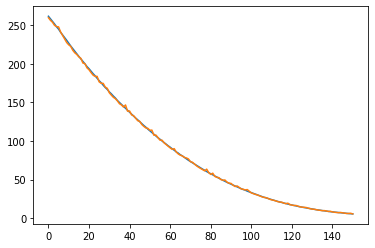

In [196]:
#val_loss = [i.detach().numpy() for i in val_loss]
#train_loss = [i.detach().numpy() for i in train_loss]
plt.plot(train_loss[10:])
plt.plot(val_loss[10:])

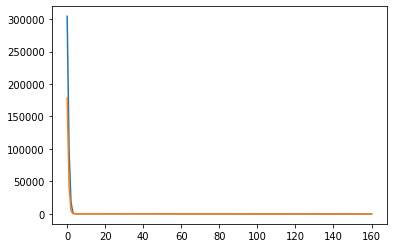

In [197]:
plt.plot(train_loss)
plt.plot(val_loss)

In [198]:
def check_train_mse(lr_model, train_city_dataset):
    criterion = torch.nn.MSELoss()
    cum_loss = 0
    for X, labels in train_city_dataset:
        curr = X.reshape((100)).tolist()
        outputs = []
        for i in np.arange(60):
            out = lr_model.forward(torch.FloatTensor(curr)).detach().numpy().tolist()
            curr = curr[2:]
            curr = curr + out
            outputs.append(out)
        loss = criterion(torch.tensor(outputs), torch.tensor(labels))
        cum_loss += loss.item()
    return cum_loss / len(train_city_dataset)

def return_predictions(lr_model, test_city_dataset):
    outp = []
    for X in test_city_dataset:
        curr = X.reshape((100)).tolist()
        outputs = []
        for i in np.arange(60):
            out = lr_model.forward(torch.FloatTensor(curr)).detach().numpy().tolist()
            curr = curr[2:]
            curr = curr + out
            outputs.append(out)
        outp.append(outputs)
    return outp

In [255]:
def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])

saved_model = linearRegression(100, 2)
saved_model.load_state_dict(torch.load("models2/austin_model_best_avg.zip"))
outp = []
real_outp = []
all_X = []
for i in np.arange(4):
    X, labels = train_city_datasets[0][i+10]
    curr = X.reshape((100)).tolist()
    outputs = []
    for i in np.arange(60):
        out = saved_model.forward(torch.FloatTensor(curr)).detach().numpy().tolist()
        curr = curr[2:]
        curr = curr + out
        outputs.append(out)
    all_X.append(torch.Tensor(X))
    outp.append(torch.Tensor(outputs))
    real_outp.append(torch.Tensor(labels))

In [256]:
a = torch.Tensor(4, 50, 2)
torch.cat(all_X, out=a)
b = torch.Tensor(4, 60, 2)
torch.cat(outp, out=b)
c = torch.Tensor(4, 60, 2)
torch.cat(real_outp, out=c);

In [257]:
a = a.reshape(4,50,2)
b = b.reshape(4,60,2)
c = c.reshape(4,60,2)

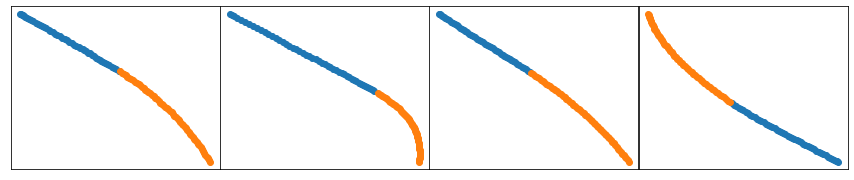

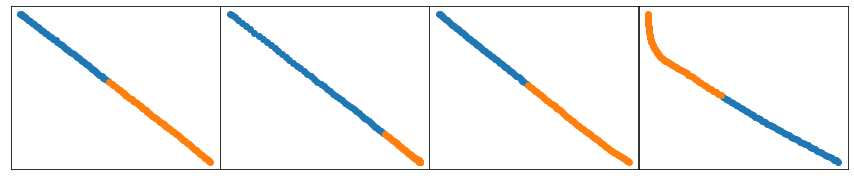

In [258]:
show_sample_batch((a, b))
show_sample_batch((a, c))

In [190]:
saved_model = linearRegression(100, 2)
saved_model.load_state_dict(torch.load("models2/austin_model_best_avg"))
#austin_pred = return_predictions(saved_model, test_city_datasets[0])
check_train_mse(saved_model, train_city_datasets[0])

53.80840036364207

In [411]:
final_train_miami, final_valid_miami = make_valid_set(train_inp_miami, train_out_miami)
final_X_train_miami, final_y_train_miami = final_train_miami
final_X_valid_miami, final_y_valid_miami = final_valid_miami
final_X_train_miami = Variable(torch.Tensor(final_X_train_miami))
final_y_train_miami = Variable(torch.Tensor(final_y_train_miami))
final_X_valid_miami = Variable(torch.Tensor(final_X_valid_miami))
final_y_valid_miami = Variable(torch.Tensor(final_y_valid_miami))
    

In [527]:
num_epochs = 5000 #1000 epochs
learning_rate = 0.00001 #0.001 lr

input_size = 2 #number of features
hidden_size = 128 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 2 #number of output classes 
batch_size = 32

lr = linearRegression(100, num_classes)
lr.load_state_dict(torch.load("models2/miami_model_best_avg"))
criterion = torch.nn.MSELoss()
#optimizer = torch.optim.Adam(lstm2.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(lr.parameters(), lr=learning_rate)
best_v_loss = 100000
best_avg_loss = 100000
best_t_loss = 100000
best_avg_loss2 = 100000

mtrain_miamiX, mtrain_miamiY = create_input(final_X_train_miami, final_y_train_miami, 50)
mval_miamiX, mval_miamiY = create_input(final_X_valid_miami, final_y_valid_miami, 50)

train_data = []
for i in range(len(mtrain_miamiX)):
    train_data.append([mtrain_miamiX[i], mtrain_miamiY[i]])
    
val_data = []
for i in range(len(mval_miamiX)):
    val_data.append([mval_miamiX[i], mval_miamiY[i]])

training_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
validation_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=True)

In [568]:
for epoch in range(num_epochs + 1):
    running_loss = 0.
    last_loss = 0.
    
    for i, data in enumerate(training_loader):
        inputs, labels = data
        inputs = inputs.float()
        labels = labels.float()
        outputs = lr.forward(inputs.reshape(32, 100)) #forward pass
        optimizer.zero_grad() #caluclate the gradient, manually setting to 0

        # obtain the loss function
        loss = criterion(outputs, labels)

        loss.backward() #calculates the loss of the loss function

        optimizer.step() #improve from loss, i.e backprop
        
        running_loss += loss.item()
    
    running_vloss = 0.
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        vinputs = vinputs.float()
        vlabels = vlabels.float()
        voutputs = lr.forward(vinputs.reshape(32, 100))
        vloss = criterion(voutputs, vlabels)
        running_vloss += vloss 
    
    last_loss = running_loss / len(training_loader) # loss per batch
    last_vloss = running_vloss/len(validation_loader)
    
    if last_loss < best_t_loss:
        best_t_loss = last_loss
        model_path = 'models2/miami_model_best_t'
        torch.save(lr.state_dict(), model_path)
    if last_vloss < best_v_loss:
        best_v_loss = last_vloss
        model_path = 'models2/miami_model_best_v'
        torch.save(lr.state_dict(), model_path)
    if (last_loss + last_vloss) / 2 < best_avg_loss:
        best_avg_loss = (last_loss + last_vloss) / 2
        model_path = 'models2/miami_model_best_avg'
        torch.save(lr.state_dict(), model_path)
    
    
    torch.save(lr.state_dict(), model_path)
    
    if epoch % 100 == 0:
        print('  batch {} loss: {} val-loss: {}'.format(epoch, last_loss, running_vloss / len(validation_loader)))

  batch 0 loss: 0.1364391774128784 val-loss: 0.17476724088191986


KeyboardInterrupt: 

In [192]:
saved_model = linearRegression(100, 2)
saved_model.load_state_dict(torch.load("models2/miami_model_best_avg"))
#miami_pred = return_predictions(saved_model, test_city_datasets[1])
check_train_mse(saved_model, train_city_datasets[1])

34.73982789230729

In [439]:
final_train_pittsburgh, final_valid_pittsburgh = make_valid_set(train_inp_pittsburgh, train_out_pittsburgh)
final_X_train_pittsburgh, final_y_train_pittsburgh = final_train_pittsburgh
final_X_valid_pittsburgh, final_y_valid_pittsburgh = final_valid_pittsburgh
final_X_train_pittsburgh = Variable(torch.Tensor(final_X_train_pittsburgh))
final_y_train_pittsburgh = Variable(torch.Tensor(final_y_train_pittsburgh))
final_X_valid_pittsburgh = Variable(torch.Tensor(final_X_valid_pittsburgh))
final_y_valid_pittsburgh = Variable(torch.Tensor(final_y_valid_pittsburgh))

mtrain_pittsburghX, mtrain_pittsburghY = create_input(final_X_train_pittsburgh, final_y_train_pittsburgh, 50)
mval_pittsburghX, mval_pittsburghY = create_input(final_X_valid_pittsburgh, final_y_valid_pittsburgh, 50)




In [ ]:
train_data = []
for i in range(len(mtrain_pittsburghX)):
    train_data.append([mtrain_pittsburghX[i], mtrain_pittsburghY[i]])
    
val_data = []
for i in range(len(mval_pittsburghX)):
    val_data.append([mval_pittsburghX[i], mval_pittsburghY[i]])

    
num_epochs = 8000 #1000 epochs
learning_rate = 0.00001 #0.001 lr

input_size = 2 #number of features
hidden_size = 128 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 2 #number of output classes 
batch_size = 32

training_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
validation_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=True)

lr = linearRegression(100, num_classes)
lr.load_state_dict(torch.load("models2/pittsburgh_model_best_avg"))
criterion = torch.nn.MSELoss()
#optimizer = torch.optim.Adam(lstm2.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(lr.parameters(), lr=learning_rate)
best_v_loss = 100000
best_avg_loss = 100000
best_t_loss = 100000
best_avg_loss2 = 100000

In [ ]:
for epoch in range(num_epochs + 1):
    running_loss = 0.
    last_loss = 0.
    
    for i, data in enumerate(training_loader):
        inputs, labels = data
        inputs = inputs.float()
        labels = labels.float()
        outputs = lr.forward(inputs.reshape(32, 100)) #forward pass
        optimizer.zero_grad() #caluclate the gradient, manually setting to 0

        # obtain the loss function
        loss = criterion(outputs, labels)

        loss.backward() #calculates the loss of the loss function

        optimizer.step() #improve from loss, i.e backprop
        
        running_loss += loss.item()
    
    running_vloss = 0.
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        vinputs = vinputs.float()
        vlabels = vlabels.float()
        voutputs = lr.forward(vinputs.reshape(32, 100))
        vloss = criterion(voutputs, vlabels)
        running_vloss += vloss 
    
    last_loss = running_loss / len(training_loader) # loss per batch
    last_vloss = running_vloss / len(validation_loader)
    
    if last_loss < best_t_loss:
        best_t_loss = last_loss
        model_path = 'models2/pittsburgh_model_best_t'
        torch.save(lr.state_dict(), model_path)
    if last_vloss < best_v_loss:
        best_v_loss = last_vloss
        model_path = 'models2/pittsburgh_model_best_v'
        torch.save(lr.state_dict(), model_path)
    if (last_loss + last_vloss) / 2 < best_avg_loss:
        best_avg_loss = (last_loss + last_vloss) / 2
        model_path = 'models2/pittsburgh_model_best_avg'
        torch.save(lr.state_dict(), model_path)
        
    torch.save(lr.state_dict(), model_path)
    if epoch % 100 == 0:
        print('  batch {} loss: {} val-loss: {}'.format(epoch, last_loss, running_vloss / len(validation_loader)))

In [193]:
saved_model = linearRegression(100, 2)
saved_model.load_state_dict(torch.load("models2/pittsburgh_model_best_avg"))
#pittsburgh_pred = return_predictions(saved_model, test_city_datasets[2])
check_train_mse(saved_model, train_city_datasets[2])

38.799510478548726

In [442]:
final_train_dearborn, final_valid_dearborn = make_valid_set(train_inp_dearborn, train_out_dearborn)
final_X_train_dearborn, final_y_train_dearborn = final_train_dearborn
final_X_valid_dearborn, final_y_valid_dearborn = final_valid_dearborn
final_X_train_dearborn = Variable(torch.Tensor(final_X_train_dearborn))
final_y_train_dearborn = Variable(torch.Tensor(final_y_train_dearborn))
final_X_valid_dearborn = Variable(torch.Tensor(final_X_valid_dearborn))
final_y_valid_dearborn = Variable(torch.Tensor(final_y_valid_dearborn))

mtrain_dearbornX, mtrain_dearbornY = create_input(final_X_train_dearborn, final_y_train_dearborn, 50)
mval_dearbornX, mval_dearbornY = create_input(final_X_valid_dearborn, final_y_valid_dearborn, 50)


In [515]:
mtrain_dearbornX, mtrain_dearbornY = create_input(final_X_train_dearborn, final_y_train_dearborn, 50)
mval_dearbornX, mval_dearbornY = create_input(final_X_valid_dearborn, final_y_valid_dearborn, 50)

train_data = []
for i in range(len(mtrain_dearbornX)):
    train_data.append([mtrain_dearbornX[i], mtrain_dearbornY[i]])
    
val_data = []
for i in range(len(mval_dearbornX)):
    val_data.append([mval_dearbornX[i], mval_dearbornY[i]])

    
num_epochs = 20000 #1000 epochs
learning_rate = 0.00001 #0.001 lr

input_size = 2 #number of features
hidden_size = 128 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 2 #number of output classes 
batch_size = 32

training_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
validation_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=True)

lr = linearRegression(100, num_classes)
lr.load_state_dict(torch.load("models2/dearborn_model_best_avg2"))
criterion = torch.nn.MSELoss()
#optimizer = torch.optim.Adam(lstm2.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(lr.parameters(), lr=learning_rate)
best_v_loss = 100000
best_avg_loss2 = 100000
best_avg_loss = 100000
best_t_loss = 100000

In [516]:
for epoch in range(num_epochs + 1):
    running_loss = 0.
    last_loss = 0.
    
    for i, data in enumerate(training_loader):
        inputs, labels = data
        inputs = inputs.float()
        labels = labels.float()
        outputs = lr.forward(inputs.reshape(batch_size, 100)) #forward pass
        optimizer.zero_grad() #caluclate the gradient, manually setting to 0

        # obtain the loss function
        loss = criterion(outputs, labels)

        loss.backward() #calculates the loss of the loss function

        optimizer.step() #improve from loss, i.e backprop
        
        running_loss += loss.item()
    
    running_vloss = 0.
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        vinputs = vinputs.float()
        vlabels = vlabels.float()
        voutputs = lr.forward(vinputs.reshape(batch_size, 100))
        vloss = criterion(voutputs, vlabels)
        running_vloss += vloss 
    
    last_loss = running_loss / len(training_loader) # loss per batch
    last_vloss = running_vloss / len(validation_loader)
    
    if last_loss < best_t_loss:
        best_t_loss = last_loss
        model_path = 'models2/dearborn_model_best_t2'
        torch.save(lr.state_dict(), model_path)
    if last_vloss < best_v_loss:
        best_v_loss = last_vloss
        model_path = 'models2/dearborn_model_best_v2'
        torch.save(lr.state_dict(), model_path)
    if (last_loss + last_vloss) / 2 < best_avg_loss:
        best_avg_loss = (last_loss + last_vloss) / 2
        model_path = 'models2/dearborn_model_best_avg2'
        torch.save(lr.state_dict(), model_path)
    
    if last_loss * 0.8 + last_vloss * 0.2 < best_avg_loss2:
        best_avg_loss2 = last_loss * 0.8 + last_vloss * 0.2
        model_path = 'models2/dearborn_model_best_w2'
        torch.save(lr.state_dict(), model_path)
    
    torch.save(lr.state_dict(), model_path)
    if epoch % 100 == 0:
        print('  batch {} loss: {} val-loss: {}'.format(epoch, last_loss, running_vloss / len(validation_loader)))

  batch 0 loss: 0.59412295879787 val-loss: 0.3753969669342041
  batch 100 loss: 0.4299960179580604 val-loss: 0.4515989124774933
  batch 200 loss: 0.4569693150672507 val-loss: 0.3369067907333374
  batch 300 loss: 0.46631153591233265 val-loss: 0.33490756154060364
  batch 400 loss: 0.48352716293692005 val-loss: 0.34659817814826965
  batch 500 loss: 0.4701041050023611 val-loss: 0.41149070858955383
  batch 600 loss: 0.44652683035441587 val-loss: 0.38565850257873535
  batch 700 loss: 0.43979514325601576 val-loss: 0.36650022864341736
  batch 800 loss: 0.43474720055069743 val-loss: 0.7397652268409729


KeyboardInterrupt: 

In [194]:
saved_model = linearRegression(100, 2)
saved_model.load_state_dict(torch.load("models2/dearborn_model_best_avg2"))
#dearborn_pred = return_predictions(saved_model, test_city_datasets[3])
check_train_mse(saved_model, train_city_datasets[3])

103.58051149718356

In [444]:
final_train_dc, final_valid_dc = make_valid_set(train_inp_dc, train_out_dc)
final_X_train_dc, final_y_train_dc = final_train_dc
final_X_valid_dc, final_y_valid_dc = final_valid_dc
final_X_train_dc = Variable(torch.Tensor(final_X_train_dc))
final_y_train_dc = Variable(torch.Tensor(final_y_train_dc))
final_X_valid_dc = Variable(torch.Tensor(final_X_valid_dc))
final_y_valid_dc = Variable(torch.Tensor(final_y_valid_dc))

mtrain_dcX, mtrain_dcY = create_input(final_X_train_dc, final_y_train_dc, 50)
mval_dcX, mval_dcY = create_input(final_X_valid_dc, final_y_valid_dc, 50)

In [450]:
train_data = []
for i in range(len(mtrain_dcX)):
    train_data.append([mtrain_dcX[i], mtrain_dcY[i]])
    
val_data = []
for i in range(len(mval_dcX)):
    val_data.append([mval_dcX[i], mval_dcY[i]])

    
num_epochs = 20000 #1000 epochs
learning_rate = 0.00001 #0.001 lr

input_size = 2 #number of features
hidden_size = 128 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 2 #number of output classes 
batch_size = 32

training_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
validation_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=True)

lr = linearRegression(100, num_classes)
lr.load_state_dict(torch.load("models2/dc_model_best_avg"))
criterion = torch.nn.MSELoss()
#optimizer = torch.optim.Adam(lstm2.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(lr.parameters(), lr=learning_rate)
best_v_loss = 100000
best_avg_loss = 100000
best_t_loss = 100000

In [452]:
for epoch in range(num_epochs + 1):
    running_loss = 0.
    last_loss = 0.
    
    for i, data in enumerate(training_loader):
        inputs, labels = data
        inputs = inputs.float()
        labels = labels.float()
        outputs = lr.forward(inputs.reshape(32, 100)) #forward pass
        optimizer.zero_grad() #caluclate the gradient, manually setting to 0

        # obtain the loss function
        loss = criterion(outputs, labels)

        loss.backward() #calculates the loss of the loss function

        optimizer.step() #improve from loss, i.e backprop
        
        running_loss += loss.item()
    
    running_vloss = 0.
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        vinputs = vinputs.float()
        vlabels = vlabels.float()
        voutputs = lr.forward(vinputs.reshape(32, 100))
        vloss = criterion(voutputs, vlabels)
        running_vloss += vloss 
    
    last_loss = running_loss / len(training_loader) # loss per batch
    last_vloss = running_vloss / len(validation_loader)
    
    if last_loss < best_t_loss:
        best_t_loss = last_loss
        model_path = 'models2/dc_model_best_t'
        torch.save(lr.state_dict(), model_path)
    if last_vloss < best_v_loss:
        best_v_loss = last_vloss
        model_path = 'models2/dc_model_best_v'
        torch.save(lr.state_dict(), model_path)
    if (last_loss + last_vloss) / 2 < best_avg_loss:
        best_avg_loss = (last_loss + last_vloss) / 2
        model_path = 'models2/dc_model_best_avg'
        torch.save(lr.state_dict(), model_path)
        
    torch.save(lr.state_dict(), model_path)
    if epoch % 100 == 0:
        print('  batch {} loss: {} val-loss: {}'.format(epoch, last_loss, running_vloss / len(validation_loader)))

  batch 0 loss: 0.21929856753020227 val-loss: 0.15463510155677795
  batch 100 loss: 0.18919025498267095 val-loss: 0.3475136160850525
  batch 200 loss: 0.19356327885139044 val-loss: 0.20518629252910614
  batch 300 loss: 0.19466428857290913 val-loss: 0.1863701194524765
  batch 400 loss: 0.1978826748140585 val-loss: 0.1999502032995224
  batch 500 loss: 0.19329428115445385 val-loss: 0.15210440754890442
  batch 600 loss: 0.19637170544656032 val-loss: 0.18579590320587158
  batch 700 loss: 0.19007914967568443 val-loss: 0.18184910714626312
  batch 800 loss: 0.19153461714809641 val-loss: 0.14983996748924255
  batch 900 loss: 0.19371615829957217 val-loss: 0.4063776433467865
  batch 1000 loss: 0.19454149617400732 val-loss: 0.15694907307624817
  batch 1100 loss: 0.18780655320009584 val-loss: 0.17010599374771118
  batch 1200 loss: 0.18687205051374658 val-loss: 0.15316422283649445
  batch 1300 loss: 0.18735958372197847 val-loss: 0.1527015119791031
  batch 1400 loss: 0.20138925436194727 val-loss: 0.1

KeyboardInterrupt: 

In [195]:
saved_model = linearRegression(100, 2)
saved_model.load_state_dict(torch.load("models2/dc_model_best_avg"))
#dc_pred = return_predictions(saved_model, test_city_datasets[4])
check_train_mse(saved_model, train_city_datasets[4])

75.82139023778095

In [447]:
final_train_palo_alto, final_valid_palo_alto = make_valid_set(train_inp_palo_alto, train_out_palo_alto)
final_X_train_palo_alto, final_y_train_palo_alto = final_train_palo_alto
final_X_valid_palo_alto, final_y_valid_palo_alto = final_valid_palo_alto
final_X_train_palo_alto = Variable(torch.Tensor(final_X_train_palo_alto))
final_y_train_palo_alto = Variable(torch.Tensor(final_y_train_palo_alto))
final_X_valid_palo_alto = Variable(torch.Tensor(final_X_valid_palo_alto))
final_y_valid_palo_alto = Variable(torch.Tensor(final_y_valid_palo_alto))

mtrain_palo_altoX, mtrain_palo_altoY = create_input(final_X_train_palo_alto, final_y_train_palo_alto, 50)
mval_palo_altoX, mval_palo_altoY = create_input(final_X_valid_palo_alto, final_y_valid_palo_alto, 50)




In [ ]:
train_data = []
for i in range(len(mtrain_palo_altoX)):
    train_data.append([mtrain_palo_altoX[i], mtrain_palo_altoY[i]])
    
val_data = []
for i in range(len(mval_palo_altoX)):
    val_data.append([mval_palo_altoX[i], mval_palo_altoY[i]])

    
num_epochs = 20000 #1000 epochs
learning_rate = 0.00001 #0.001 lr

input_size = 2 #number of features
hidden_size = 128 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 2 #number of output classes 
batch_size = 32

training_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
validation_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=True)

lr = linearRegression(100, num_classes)
lr.load_state_dict(torch.load("models2/palo_alto_model_best_avg"))
criterion = torch.nn.MSELoss()
#optimizer = torch.optim.Adam(lstm2.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(lr.parameters(), lr=learning_rate)
best_v_loss = 100000
best_avg_loss = 100000
best_t_loss = 100000

In [448]:
for epoch in range(num_epochs + 1):
    running_loss = 0.
    last_loss = 0.
    
    for i, data in enumerate(training_loader):
        inputs, labels = data
        inputs = inputs.float()
        labels = labels.float()
        outputs = lr.forward(inputs.reshape(32, 100)) #forward pass
        optimizer.zero_grad() #caluclate the gradient, manually setting to 0

        # obtain the loss function
        loss = criterion(outputs, labels)

        loss.backward() #calculates the loss of the loss function

        optimizer.step() #improve from loss, i.e backprop
        
        running_loss += loss.item()
    
    running_vloss = 0.
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        vinputs = vinputs.float()
        vlabels = vlabels.float()
        voutputs = lr.forward(vinputs.reshape(32, 100))
        vloss = criterion(voutputs, vlabels)
        running_vloss += vloss 
    
    last_loss = running_loss / len(training_loader) # loss per batch
    last_vloss = running_vloss / len(validation_loader)
    
    if last_loss < best_t_loss:
        best_t_loss = last_loss
        model_path = 'models2/palo_alto_model_best_t'
        torch.save(lr.state_dict(), model_path)
    if last_vloss < best_v_loss:
        best_v_loss = last_vloss
        model_path = 'models2/palo_alto_model_best_v'
        torch.save(lr.state_dict(), model_path)
    if (last_loss + last_vloss) / 2 < best_avg_loss:
        best_avg_loss = (last_loss + last_vloss) / 2
        model_path = 'models2/palo_alto_model_best_avg'
        torch.save(lr.state_dict(), model_path)
        
    torch.save(lr.state_dict(), model_path)
    if epoch % 100 == 0:
        print('  batch {} loss: {} val-loss: {}'.format(epoch, last_loss, running_vloss / len(validation_loader)))

  batch 0 loss: 2404873.100543478 val-loss: 2000624.25
  batch 100 loss: 182.2635923659921 val-loss: 187.74105834960938
  batch 200 loss: 85.18158344281557 val-loss: 87.98871612548828
  batch 300 loss: 28.780860049270068 val-loss: 29.572784423828125
  batch 400 loss: 5.8241060410056225 val-loss: 6.1202497482299805
  batch 500 loss: 1.4519809777521369 val-loss: 1.4400074481964111
  batch 600 loss: 1.2912982279640377 val-loss: 1.2501935958862305
  batch 700 loss: 1.242678406645223 val-loss: 1.1793487071990967
  batch 800 loss: 1.2044325231708413 val-loss: 1.196580171585083
  batch 900 loss: 1.163171501462675 val-loss: 1.1491758823394775
  batch 1000 loss: 1.1693313456698007 val-loss: 1.2764590978622437
  batch 1100 loss: 1.1423317400308757 val-loss: 1.0776869058609009
  batch 1200 loss: 1.1036122809086357 val-loss: 1.1146605014801025
  batch 1300 loss: 1.1143466678750156 val-loss: 1.1312785148620605
  batch 1400 loss: 1.0590391502930567 val-loss: 1.1505273580551147
  batch 1500 loss: 1.0

KeyboardInterrupt: 

In [196]:
saved_model = linearRegression(100, 2)
saved_model.load_state_dict(torch.load("models2/palo_alto_model_best_avg"))
#palo_alto_pred = return_predictions(saved_model, test_city_datasets[5])
check_train_mse(saved_model, train_city_datasets[5])

66.81033034615746

In [561]:
df2 = pd.read_csv('avg2.csv', index_col="ID")
dearborn_pred = numpy.array(df2.loc[[str(i) + "_dearborn" for i in np.arange(len(test_city_datasets[3]))]].values.tolist()).reshape(len(test_city_datasets[3]), 60, 2)

In [ ]:
dearborn_pred

(6361, 60, 2)

In [554]:
np.shape(pred_combined)

(32533, 60, 2)

In [480]:

running_loss = 0.
last_loss = 0.

for i, data in enumerate(training_loader):
    inputs, labels = data
    inputs = inputs.float()
    labels = labels.float()
    #outputs = lstm1.forward(inputs) #forward pass
    #optimizer.zero_grad() #caluclate the gradient, manually setting to 0
    # obtain the loss function
    loss = criterion(inputs[:,49:].reshape(32, 2), labels)

    #loss.backward() #calculates the loss of the loss function

    #optimizer.step() #improve from loss, i.e backprop

    running_loss += loss.item()

#running_vloss = 0.
#for i, vdata in enumerate(validation_loader):
#    vinputs, vlabels = vdata
#    vinputs = vinputs.float()
#    vlabels = vlabels.float()
#    voutputs = lstm1.forward(vinputs)
#    vloss = criterion(voutputs, vlabels)
#     running_vloss += vloss  
last_loss = running_loss / len(training_loader) # loss per batch
print(last_loss)

0.48723154172374455


In [570]:
pred_combined = np.concatenate((austin_pred, miami_pred, pittsburgh_pred, dearborn_pred, dc_pred, palo_alto_pred))
df3 = pd.DataFrame(pred_combined.reshape(29843, 120))
df3 = df.rename(columns=dict(zip(np.arange(120), ["v" + str(i) for i in np.arange(120)])))
idd = ([str(i) + "_austin" for i in np.arange(len(test_city_datasets[0]))] +
       [str(i) + "_miami" for i in np.arange(len(test_city_datasets[1]))] +
       [str(i) + "_pittsburgh" for i in np.arange(len(test_city_datasets[2]))] +
       [str(i) + "_dearborn" for i in np.arange(len(test_city_datasets[3]))] +
       [str(i) + "_washington-dc" for i in np.arange(len(test_city_datasets[4]))] +
       [str(i) + "_palo-alto" for i in np.arange(len(test_city_datasets[5]))])
df3.insert(loc=0, column='ID', value=idd)
df3

ValueError: cannot insert ID, already exists

In [571]:
df3.to_csv("avg7.csv", index=False)

In [249]:
from sklearn.model_selection import train_test_split
def make_valid_set(train_inp, train_out, train_subset = 0.8):
    if len(train_inp) != len(train_out):
        raise ValueError("Input and output lengths should be the same!")
        
    X_train, X_test, y_train, y_test = train_test_split(train_inp, train_out, test_size=(1-train_subset), random_state=42)
    
    return (X_train, y_train), (X_test, y_test)

In [260]:
from torch.autograd import Variable 
final_train_austin, final_valid_austin = make_valid_set(train_inp_austin, train_out_austin)
final_X_train_austin, final_y_train_austin = final_train_austin
final_X_valid_austin, final_y_valid_austin = final_valid_austin
final_X_train_austin = Variable(torch.Tensor(final_X_train_austin))
final_y_train_austin = Variable(torch.Tensor(final_y_train_austin))
final_X_valid_austin = Variable(torch.Tensor(final_X_valid_austin))
final_y_valid_austin = Variable(torch.Tensor(final_y_valid_austin))

train_data = []
for i in range(len(final_X_train_austin)):
    train_data.append([final_X_train_austin[i], final_y_train_austin[i]])
    
val_data = []
for i in range(len(final_X_valid_austin)):
    val_data.append([final_X_valid_austin[i], final_y_valid_austin[i]])

In [261]:
num_epochs = 25 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 2 #number of features
hidden_size = 128 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 120 #number of output classes 
batch_size = 64

In [262]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, final_X_train_austin.shape[1])

In [263]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

In [264]:


training_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
validation_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=True)


for epoch in range(num_epochs):
    running_loss = 0.
    last_loss = 0.
    
    for i, data in enumerate(training_loader):
        inputs, labels = data
        inputs = inputs.float()
        labels = labels.float()
        outputs = lstm1.forward(inputs) #forward pass
        labels = torch.reshape(labels, (batch_size, 120))
        optimizer.zero_grad() #caluclate the gradient, manually setting to 0

        # obtain the loss function
        loss = criterion(outputs, labels)

        loss.backward() #calculates the loss of the loss function

        optimizer.step() #improve from loss, i.e backprop
        
        running_loss += loss.item()
    
    running_vloss = 0.
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        vinputs = vinputs.float()
        vlabels = vlabels.float()
        voutputs = lstm1.forward(vinputs)
        vlabels = torch.reshape(vlabels, (batch_size, 120))
        vloss = criterion(voutputs, vlabels)
        running_vloss += vloss  
    last_loss = running_loss / len(training_loader) # loss per batch
    last_vloss = running_vloss / len(validation_loader)
    
    model_path = 'models/austin_model_{}'.format(epoch)
    torch.save(lstm1.state_dict(), model_path)
        
    print('  batch {} loss: {} val-loss: {}'.format(epoch, last_loss, last_vloss))

KeyboardInterrupt: 

In [287]:
saved_model =  LSTM1(num_classes, input_size, hidden_size, num_layers, final_X_train_austin.shape[1])
saved_model.load_state_dict(torch.load("models/austin_model_22"))
austin_pred = saved_model(Variable(torch.Tensor(test_city_datasets[0])))

In [290]:
from torch.autograd import Variable 
final_train_miami, final_valid_miami = make_valid_set(train_inp_miami, train_out_miami)
final_X_train_miami, final_y_train_miami = final_train_miami
final_X_valid_miami, final_y_valid_miami = final_valid_miami
final_X_train_miami = Variable(torch.Tensor(final_X_train_miami))
final_y_train_miami = Variable(torch.Tensor(final_y_train_miami))
final_X_valid_miami = Variable(torch.Tensor(final_X_valid_miami))
final_y_valid_miami = Variable(torch.Tensor(final_y_valid_miami))

train_data = []
for i in range(len(final_X_train_miami)):
    train_data.append([final_X_train_miami[i], final_y_train_miami[i]])
    
val_data = []
for i in range(len(final_X_valid_miami)):
    val_data.append([final_X_valid_miami[i], final_y_valid_miami[i]])
    
num_epochs = 25 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 2 #number of features
hidden_size = 128 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 120 #number of output classes 
batch_size = 128

lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, final_X_train_miami.shape[1])
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

training_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
validation_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=True)


for epoch in range(num_epochs):
    running_loss = 0.
    last_loss = 0.
    
    for i, data in enumerate(training_loader):
        inputs, labels = data
        inputs = inputs.float()
        labels = labels.float()
        outputs = lstm1.forward(inputs) #forward pass
        labels = torch.reshape(labels, (batch_size, 120))
        optimizer.zero_grad() #caluclate the gradient, manually setting to 0

        # obtain the loss function
        loss = criterion(outputs, labels)

        loss.backward() #calculates the loss of the loss function

        optimizer.step() #improve from loss, i.e backprop
        
        running_loss += loss.item()
    
    running_vloss = 0.
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        vinputs = vinputs.float()
        vlabels = vlabels.float()
        voutputs = lstm1.forward(vinputs)
        vlabels = torch.reshape(vlabels, (batch_size, 120))
        vloss = criterion(voutputs, vlabels)
        running_vloss += vloss  
    last_loss = running_loss / len(training_loader) # loss per batch
    last_vloss = running_vloss / len(validation_loader)
    
    model_path = 'models/miami_model_{}'.format(epoch)
    torch.save(lstm1.state_dict(), model_path)
        
    print('  batch {} loss: {} val-loss: {}'.format(epoch, last_loss, last_vloss))

  batch 0 loss: 9474897.943148687 val-loss: 6857995.5
  batch 1 loss: 4480666.054664723 val-loss: 2448826.25
  batch 2 loss: 1415608.4742164724 val-loss: 862530.75
  batch 3 loss: 614085.7105047376 val-loss: 449836.1875
  batch 4 loss: 338476.74599125364 val-loss: 256899.3125
  batch 5 loss: 218824.63431577987 val-loss: 175128.046875
  batch 6 loss: 133786.6623428389 val-loss: 106764.578125
  batch 7 loss: 93563.87455584912 val-loss: 78818.203125
  batch 8 loss: 65176.00657684949 val-loss: 60564.1171875
  batch 9 loss: 54583.42058810131 val-loss: 50377.9765625
  batch 10 loss: 45447.32589001002 val-loss: 47506.0234375
  batch 11 loss: 42187.27964137664 val-loss: 40089.0546875
  batch 12 loss: 36611.39542524599 val-loss: 41668.99609375
  batch 13 loss: 35082.924303594205 val-loss: 27343.009765625
  batch 14 loss: 39950.72769850127 val-loss: 35657.58984375
  batch 15 loss: 42714.988728248 val-loss: 37006.2109375
  batch 16 loss: 48476.45683479865 val-loss: 47387.03515625
  batch 17 loss:

In [292]:
saved_model =  LSTM1(num_classes, input_size, hidden_size, num_layers, final_X_train_miami.shape[1])
saved_model.load_state_dict(torch.load("models/miami_model_21"))
miami_pred = saved_model(Variable(torch.Tensor(test_city_datasets[1])))

In [295]:
from torch.autograd import Variable 
final_train_pittsburgh, final_valid_pittsburgh = make_valid_set(train_inp_pittsburgh, train_out_pittsburgh)
final_X_train_pittsburgh, final_y_train_pittsburgh = final_train_pittsburgh
final_X_valid_pittsburgh, final_y_valid_pittsburgh = final_valid_pittsburgh
final_X_train_pittsburgh = Variable(torch.Tensor(final_X_train_pittsburgh))
final_y_train_pittsburgh = Variable(torch.Tensor(final_y_train_pittsburgh))
final_X_valid_pittsburgh = Variable(torch.Tensor(final_X_valid_pittsburgh))
final_y_valid_pittsburgh = Variable(torch.Tensor(final_y_valid_pittsburgh))

train_data = []
for i in range(len(final_X_train_pittsburgh)):
    train_data.append([final_X_train_pittsburgh[i], final_y_train_pittsburgh[i]])
    
val_data = []
for i in range(len(final_X_valid_pittsburgh)):
    val_data.append([final_X_valid_pittsburgh[i], final_y_valid_pittsburgh[i]])
    
num_epochs = 25 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 2 #number of features
hidden_size = 128 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 120 #number of output classes 
batch_size = 64

lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, final_X_train_pittsburgh.shape[1])
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

training_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
validation_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=True)


for epoch in range(num_epochs):
    running_loss = 0.
    last_loss = 0.
    
    for i, data in enumerate(training_loader):
        inputs, labels = data
        inputs = inputs.float()
        labels = labels.float()
        outputs = lstm1.forward(inputs) #forward pass
        labels = torch.reshape(labels, (batch_size, 120))
        optimizer.zero_grad() #caluclate the gradient, manually setting to 0

        # obtain the loss function
        loss = criterion(outputs, labels)

        loss.backward() #calculates the loss of the loss function

        optimizer.step() #improve from loss, i.e backprop
        
        running_loss += loss.item()
    
    running_vloss = 0.
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        vinputs = vinputs.float()
        vlabels = vlabels.float()
        voutputs = lstm1.forward(vinputs)
        vlabels = torch.reshape(vlabels, (batch_size, 120))
        vloss = criterion(voutputs, vlabels)
        running_vloss += vloss  
    last_loss = running_loss / len(training_loader) # loss per batch
    last_vloss = running_vloss / len(validation_loader)
    
    model_path = 'models/pittsburgh_model_{}'.format(epoch)
    torch.save(lstm1.state_dict(), model_path)
        
    print('  batch {} loss: {} val-loss: {}'.format(epoch, last_loss, last_vloss))

  batch 0 loss: 5869006.201286765 val-loss: 2791013.0
  batch 1 loss: 1522963.6076516544 val-loss: 747893.125
  batch 2 loss: 543510.3307961856 val-loss: 394639.15625
  batch 3 loss: 358080.59748391545 val-loss: 284245.53125
  batch 4 loss: 234921.81696633733 val-loss: 164379.828125
  batch 5 loss: 129700.06961239086 val-loss: 89234.71875
  batch 6 loss: 79278.55746280446 val-loss: 57235.28125
  batch 7 loss: 49230.85797478171 val-loss: 39249.6875
  batch 8 loss: 41843.03899607939 val-loss: 37391.359375
  batch 9 loss: 33502.63472702924 val-loss: 28574.75390625
  batch 10 loss: 24930.489816104666 val-loss: 24455.974609375
  batch 11 loss: 18261.648135016945 val-loss: 20624.421875
  batch 12 loss: 17707.556951186238 val-loss: 14537.17578125
  batch 13 loss: 21732.831004423253 val-loss: 19750.537109375
  batch 14 loss: 16224.17256792854 val-loss: 15696.091796875
  batch 15 loss: 16900.461850334617 val-loss: 16949.517578125
  batch 16 loss: 15696.533732694737 val-loss: 15809.1064453125
  

In [297]:
saved_model =  LSTM1(num_classes, input_size, hidden_size, num_layers, final_X_train_miami.shape[1])
saved_model.load_state_dict(torch.load("models/pittsburgh_model_22"))
pittsburgh_pred = saved_model(Variable(torch.Tensor(test_city_datasets[2])))

In [308]:
from torch.autograd import Variable 
final_train_dearborn, final_valid_dearborn = make_valid_set(train_inp_dearborn, train_out_dearborn)
final_X_train_dearborn, final_y_train_dearborn = final_train_dearborn
final_X_valid_dearborn, final_y_valid_dearborn = final_valid_dearborn
final_X_train_dearborn = Variable(torch.Tensor(final_X_train_dearborn))
final_y_train_dearborn = Variable(torch.Tensor(final_y_train_dearborn))
final_X_valid_dearborn = Variable(torch.Tensor(final_X_valid_dearborn))
final_y_valid_dearborn = Variable(torch.Tensor(final_y_valid_dearborn))

train_data = []
for i in range(len(final_X_train_dearborn)):
    train_data.append([final_X_train_dearborn[i], final_y_train_dearborn[i]])
    
val_data = []
for i in range(len(final_X_valid_dearborn)):
    val_data.append([final_X_valid_dearborn[i], final_y_valid_dearborn[i]])
    
num_epochs = 25 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 2 #number of features
hidden_size = 128 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 120 #number of output classes 
batch_size = 256

lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, final_X_train_dearborn.shape[1])
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

training_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
validation_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=True)


for epoch in range(num_epochs):
    running_loss = 0.
    last_loss = 0.
    
    for i, data in enumerate(training_loader):
        inputs, labels = data
        inputs = inputs.float()
        labels = labels.float()
        outputs = lstm1.forward(inputs) #forward pass
        labels = torch.reshape(labels, (batch_size, 120))
        optimizer.zero_grad() #caluclate the gradient, manually setting to 0

        # obtain the loss function
        loss = criterion(outputs, labels)

        loss.backward() #calculates the loss of the loss function

        optimizer.step() #improve from loss, i.e backprop
        
        running_loss += loss.item()
    
    running_vloss = 0.
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        vinputs = vinputs.float()
        vlabels = vlabels.float()
        voutputs = lstm1.forward(vinputs)
        vlabels = torch.reshape(vlabels, (batch_size, 120))
        vloss = criterion(voutputs, vlabels)
        running_vloss += vloss  
    last_loss = running_loss / len(training_loader) # loss per batch
    last_vloss = running_vloss / len(validation_loader)
    
    model_path = 'models/dearborn_model_{}'.format(epoch)
    torch.save(lstm1.state_dict(), model_path)
        
    print('  batch {} loss: {} val-loss: {}'.format(epoch, last_loss, last_vloss))

  batch 0 loss: 40347774.421052635 val-loss: 39335388.0
  batch 1 loss: 39162692.05263158 val-loss: 37087888.0
  batch 2 loss: 35794064.684210524 val-loss: 32815842.0
  batch 3 loss: 30764915.39473684 val-loss: 27328690.0
  batch 4 loss: 25104370.47368421 val-loss: 21774124.0
  batch 5 loss: 19445242.289473683 val-loss: 16536086.0
  batch 6 loss: 14725025.881578946 val-loss: 12343312.0
  batch 7 loss: 10868233.710526315 val-loss: 9106012.0
  batch 8 loss: 8082105.822368421 val-loss: 6768371.5
  batch 9 loss: 5902458.125 val-loss: 4906096.0
  batch 10 loss: 4262928.986842105 val-loss: 3458916.0
  batch 11 loss: 3004349.049342105 val-loss: 2550219.25
  batch 12 loss: 2326806.106907895 val-loss: 2048931.125
  batch 13 loss: 1835623.4128289474 val-loss: 1644708.875
  batch 14 loss: 1544890.0476973683 val-loss: 1466004.875
  batch 15 loss: 1416522.074013158 val-loss: 1429337.125
  batch 16 loss: 1356946.2286184211 val-loss: 1299481.5
  batch 17 loss: 1325451.0411184211 val-loss: 1298326.625

In [309]:
for epoch in range(25,45):
    running_loss = 0.
    last_loss = 0.
    
    for i, data in enumerate(training_loader):
        inputs, labels = data
        inputs = inputs.float()
        labels = labels.float()
        outputs = lstm1.forward(inputs) #forward pass
        labels = torch.reshape(labels, (batch_size, 120))
        optimizer.zero_grad() #caluclate the gradient, manually setting to 0

        # obtain the loss function
        loss = criterion(outputs, labels)

        loss.backward() #calculates the loss of the loss function

        optimizer.step() #improve from loss, i.e backprop
        
        running_loss += loss.item()
    
    running_vloss = 0.
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        vinputs = vinputs.float()
        vlabels = vlabels.float()
        voutputs = lstm1.forward(vinputs)
        vlabels = torch.reshape(vlabels, (batch_size, 120))
        vloss = criterion(voutputs, vlabels)
        running_vloss += vloss  
    last_loss = running_loss / len(training_loader) # loss per batch
    last_vloss = running_vloss / len(validation_loader)
    
    model_path = 'models/dearborn_model_{}'.format(epoch)
    torch.save(lstm1.state_dict(), model_path)
        
    print('  batch {} loss: {} val-loss: {}'.format(epoch, last_loss, last_vloss))

  batch 25 loss: 917697.365131579 val-loss: 897237.5625
  batch 26 loss: 903253.5279605263 val-loss: 887291.0625
  batch 27 loss: 882663.9646381579 val-loss: 866075.3125
  batch 28 loss: 862024.2105263158 val-loss: 852694.9375
  batch 29 loss: 858405.9564144737 val-loss: 861358.5
  batch 30 loss: 842203.8577302631 val-loss: 813968.0625
  batch 31 loss: 823626.4070723684 val-loss: 820986.0
  batch 32 loss: 813221.2820723684 val-loss: 820969.9375
  batch 33 loss: 811684.7368421053 val-loss: 790145.75
  batch 34 loss: 789706.3569078947 val-loss: 796856.1875
  batch 35 loss: 797944.9087171053 val-loss: 783820.1875
  batch 36 loss: 784740.1101973684 val-loss: 765379.8125
  batch 37 loss: 756370.6455592106 val-loss: 766206.125
  batch 38 loss: 742098.416118421 val-loss: 738017.1875
  batch 39 loss: 756815.6019736842 val-loss: 756921.6875
  batch 40 loss: 740794.8083881579 val-loss: 732774.8125
  batch 41 loss: 736085.4037828947 val-loss: 712186.5625
  batch 42 loss: 708293.4638157894 val-los

  batch 45 loss: 682764.6685855263 val-loss: 665839.1875
  batch 46 loss: 662403.9728618421 val-loss: 643629.875
  batch 47 loss: 649351.8462171053 val-loss: 631649.5625
  batch 48 loss: 632460.3832236842 val-loss: 614734.0625
  batch 49 loss: 617528.3700657894 val-loss: 600081.0
  batch 50 loss: 521621.9634046053 val-loss: 498446.09375
  batch 51 loss: 429789.9136513158 val-loss: 430118.8125
  batch 52 loss: 409397.7195723684 val-loss: 414931.9375
  batch 53 loss: 402801.9962993421 val-loss: 379558.9375
  batch 54 loss: 385329.9342105263 val-loss: 389804.53125
  batch 55 loss: 368367.95929276315 val-loss: 347276.46875
  batch 56 loss: 343347.3009868421 val-loss: 335191.96875
  batch 57 loss: 328177.0127467105 val-loss: 320701.8125
  batch 58 loss: 317778.1091694079 val-loss: 304959.59375
  batch 59 loss: 299412.51726973685 val-loss: 299142.15625
  batch 60 loss: 251614.37212171053 val-loss: 217393.09375
  batch 61 loss: 213305.80016447368 val-loss: 199674.484375
  batch 62 loss: 18976

  batch 80 loss: 96188.67727179277 val-loss: 101269.3515625
  batch 81 loss: 92239.59945518093 val-loss: 90600.8671875
  batch 82 loss: 89658.7765727796 val-loss: 92474.0625
  batch 83 loss: 85001.70482113487 val-loss: 86289.75
  batch 84 loss: 94335.80931332237 val-loss: 100042.703125
  batch 85 loss: 88725.70369037829 val-loss: 83649.6015625
  batch 86 loss: 82008.98802425987 val-loss: 85583.84375
  batch 87 loss: 78342.91509046052 val-loss: 76307.8828125
  batch 88 loss: 75141.10634251645 val-loss: 75228.8203125
  batch 89 loss: 73068.91072162829 val-loss: 77206.171875
  batch 90 loss: 73384.60264185855 val-loss: 87569.9140625
  batch 91 loss: 73336.9919819079 val-loss: 73786.53125
  batch 92 loss: 69121.44197162829 val-loss: 68750.671875
  batch 93 loss: 64764.05201480263 val-loss: 64657.51171875
  batch 94 loss: 67712.17259457237 val-loss: 66520.5234375
  batch 95 loss: 67362.14134457237 val-loss: 71554.6796875
  batch 96 loss: 64771.00884046053 val-loss: 62342.82421875
  batch 97

  batch 100 loss: 57862.63306949013 val-loss: 56002.77734375
  batch 101 loss: 55973.82450143914 val-loss: 55881.67578125
  batch 102 loss: 52326.38661595395 val-loss: 52710.05859375
  batch 103 loss: 50882.87073396381 val-loss: 51120.30078125
  batch 104 loss: 49563.21892989309 val-loss: 49849.8984375
  batch 105 loss: 51890.14987664474 val-loss: 55546.47265625
  batch 106 loss: 48345.5042917352 val-loss: 47477.6875
  batch 107 loss: 45752.54361122533 val-loss: 44285.55078125
  batch 108 loss: 50603.96898129112 val-loss: 47093.0
  batch 109 loss: 44440.56692023026 val-loss: 41565.53125
  batch 110 loss: 43319.28307462994 val-loss: 44167.3046875
  batch 111 loss: 41772.90861430921 val-loss: 44289.2109375
  batch 112 loss: 40426.04379111842 val-loss: 39352.65234375
  batch 113 loss: 39247.3890573602 val-loss: 44757.47265625
  batch 114 loss: 38508.67177220395 val-loss: 36299.609375
  batch 115 loss: 41578.74146792763 val-loss: 46109.3125
  batch 116 loss: 42875.66781455592 val-loss: 408

In [313]:
for epoch in range(120,150):
    running_loss = 0.
    last_loss = 0.
    
    for i, data in enumerate(training_loader):
        inputs, labels = data
        inputs = inputs.float()
        labels = labels.float()
        outputs = lstm1.forward(inputs) #forward pass
        labels = torch.reshape(labels, (batch_size, 120))
        optimizer.zero_grad() #caluclate the gradient, manually setting to 0

        # obtain the loss function
        loss = criterion(outputs, labels)

        loss.backward() #calculates the loss of the loss function

        optimizer.step() #improve from loss, i.e backprop
        
        running_loss += loss.item()
    
    running_vloss = 0.
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        vinputs = vinputs.float()
        vlabels = vlabels.float()
        voutputs = lstm1.forward(vinputs)
        vlabels = torch.reshape(vlabels, (batch_size, 120))
        vloss = criterion(voutputs, vlabels)
        running_vloss += vloss  
    last_loss = running_loss / len(training_loader) # loss per batch
    last_vloss = running_vloss / len(validation_loader)
    
    model_path = 'models/dearborn_model_{}'.format(epoch)
    torch.save(lstm1.state_dict(), model_path)
        
    print('  batch {} loss: {} val-loss: {}'.format(epoch, last_loss, last_vloss))

  batch 120 loss: 34159.62371504934 val-loss: 32221.244140625
  batch 121 loss: 35391.30545847039 val-loss: 40562.57421875
  batch 122 loss: 33052.99910053454 val-loss: 32872.53515625
  batch 123 loss: 31161.62529553865 val-loss: 31240.55859375
  batch 124 loss: 34051.40687962582 val-loss: 32665.912109375
  batch 125 loss: 32194.391588712995 val-loss: 33223.9765625
  batch 126 loss: 28675.34495785362 val-loss: 30935.1875
  batch 127 loss: 29597.17416221217 val-loss: 32266.43359375
  batch 128 loss: 57781.42593544408 val-loss: 71870.75
  batch 129 loss: 66831.02564761513 val-loss: 52330.38671875
  batch 130 loss: 60133.95387027138 val-loss: 52870.29296875
  batch 131 loss: 45176.01652446546 val-loss: 43466.0390625
  batch 132 loss: 40507.9193307977 val-loss: 37839.26953125
  batch 133 loss: 39622.2808645148 val-loss: 40627.38671875
  batch 134 loss: 46914.40018503289 val-loss: 41667.26171875


KeyboardInterrupt: 

In [314]:
saved_model =  LSTM1(num_classes, input_size, hidden_size, num_layers, final_X_train_dearborn.shape[1])
saved_model.load_state_dict(torch.load("models/dearborn_model_126"))
dearborn_pred = saved_model(Variable(torch.Tensor(test_city_datasets[3])))

In [299]:
from torch.autograd import Variable 
final_train_dc, final_valid_dc = make_valid_set(train_inp_dc, train_out_dc)
final_X_train_dc, final_y_train_dc = final_train_dc
final_X_valid_dc, final_y_valid_dc = final_valid_dc
final_X_train_dc = Variable(torch.Tensor(final_X_train_dc))
final_y_train_dc = Variable(torch.Tensor(final_y_train_dc))
final_X_valid_dc = Variable(torch.Tensor(final_X_valid_dc))
final_y_valid_dc = Variable(torch.Tensor(final_y_valid_dc))

train_data = []
for i in range(len(final_X_train_dc)):
    train_data.append([final_X_train_dc[i], final_y_train_dc[i]])
    
val_data = []
for i in range(len(final_X_valid_dc)):
    val_data.append([final_X_valid_dc[i], final_y_valid_dc[i]])
    
num_epochs = 25 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 2 #number of features
hidden_size = 128 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 120 #number of output classes 
batch_size = 64

lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, final_X_train_dearborn.shape[1])
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

training_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
validation_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=True)


for epoch in range(num_epochs):
    running_loss = 0.
    last_loss = 0.
    
    for i, data in enumerate(training_loader):
        inputs, labels = data
        inputs = inputs.float()
        labels = labels.float()
        outputs = lstm1.forward(inputs) #forward pass
        labels = torch.reshape(labels, (batch_size, 120))
        optimizer.zero_grad() #caluclate the gradient, manually setting to 0

        # obtain the loss function
        loss = criterion(outputs, labels)

        loss.backward() #calculates the loss of the loss function

        optimizer.step() #improve from loss, i.e backprop
        
        running_loss += loss.item()
    
    running_vloss = 0.
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        vinputs = vinputs.float()
        vlabels = vlabels.float()
        voutputs = lstm1.forward(vinputs)
        vlabels = torch.reshape(vlabels, (batch_size, 120))
        vloss = criterion(voutputs, vlabels)
        running_vloss += vloss  
    last_loss = running_loss / len(training_loader) # loss per batch
    last_vloss = running_vloss / len(validation_loader)
    
    model_path = 'models/dc_model_{}'.format(epoch)
    torch.save(lstm1.state_dict(), model_path)
        
    print('  batch {} loss: {} val-loss: {}'.format(epoch, last_loss, last_vloss))

  batch 0 loss: 9385461.742990654 val-loss: 5610566.0
  batch 1 loss: 3207127.6584890964 val-loss: 1819893.75
  batch 2 loss: 1557911.9852024922 val-loss: 1283835.0
  batch 3 loss: 1078999.664330218 val-loss: 922020.125
  batch 4 loss: 747341.2122274144 val-loss: 612214.375
  batch 5 loss: 493569.289135514 val-loss: 408834.8125
  batch 6 loss: 338422.6526479751 val-loss: 299029.40625
  batch 7 loss: 256607.70497468847 val-loss: 230622.703125
  batch 8 loss: 225930.4445093458 val-loss: 197899.109375
  batch 9 loss: 180712.63062207945 val-loss: 184094.53125
  batch 10 loss: 155681.7933459891 val-loss: 141590.5625
  batch 11 loss: 118971.14840099298 val-loss: 128880.0
  batch 12 loss: 95406.00657126168 val-loss: 87752.0234375
  batch 13 loss: 90892.62417250779 val-loss: 87449.9609375
  batch 14 loss: 72366.00244596963 val-loss: 64895.48046875
  batch 15 loss: 55550.78625146028 val-loss: 60349.9453125
  batch 16 loss: 51878.24902647975 val-loss: 50345.65234375
  batch 17 loss: 42203.862420

  batch 25 loss: 20870.112566321066 val-loss: 20559.96484375
  batch 26 loss: 19240.552623332846 val-loss: 19937.3203125
  batch 27 loss: 18895.283625997858 val-loss: 19408.453125
  batch 28 loss: 17838.191768277844 val-loss: 18670.5234375
  batch 29 loss: 17205.579354069316 val-loss: 18013.62109375
  batch 30 loss: 24902.983631169685 val-loss: 20677.572265625
  batch 31 loss: 18718.877201068437 val-loss: 18639.39453125
  batch 32 loss: 17490.7750970478 val-loss: 22167.0703125
  batch 33 loss: 17033.083204037674 val-loss: 15259.2314453125
  batch 34 loss: 14312.85533336984 val-loss: 15120.251953125


  batch 35 loss: 14823.043408355237 val-loss: 15066.3251953125
  batch 36 loss: 12641.021847923968 val-loss: 11887.158203125
  batch 37 loss: 11705.64586071359 val-loss: 15463.181640625
  batch 38 loss: 14671.065326250973 val-loss: 16645.431640625
  batch 39 loss: 12465.980671059677 val-loss: 11665.5634765625
  batch 40 loss: 13225.928434092679 val-loss: 22456.814453125
  batch 41 loss: 12706.826651029498 val-loss: 10407.0947265625
  batch 42 loss: 10052.181590427863 val-loss: 10523.486328125
  batch 43 loss: 10197.307609581872 val-loss: 11657.873046875
  batch 44 loss: 9625.548239449474 val-loss: 10714.205078125


  batch 45 loss: 12262.152672313085 val-loss: 14125.080078125
  batch 46 loss: 18971.32902550623 val-loss: 14246.4609375
  batch 47 loss: 12720.046070324668 val-loss: 13153.412109375
  batch 48 loss: 12266.36843178057 val-loss: 12773.5439453125
  batch 49 loss: 10345.924377251265 val-loss: 10931.8154296875
  batch 50 loss: 10395.657048590829 val-loss: 10906.240234375
  batch 51 loss: 15797.31979075399 val-loss: 13717.3251953125


KeyboardInterrupt: 

In [303]:
saved_model =  LSTM1(num_classes, input_size, hidden_size, num_layers, final_X_train_dearborn.shape[1])
saved_model.load_state_dict(torch.load("models/dc_model_44"))
dc_pred = saved_model(Variable(torch.Tensor(test_city_datasets[4])))

In [304]:
from torch.autograd import Variable 
final_train_palo_alto, final_valid_palo_alto = make_valid_set(train_inp_palo_alto, train_out_palo_alto)
final_X_train_palo_alto, final_y_train_palo_alto = final_train_palo_alto
final_X_valid_palo_alto, final_y_valid_palo_alto = final_valid_palo_alto
final_X_train_palo_alto = Variable(torch.Tensor(final_X_train_palo_alto))
final_y_train_palo_alto = Variable(torch.Tensor(final_y_train_palo_alto))
final_X_valid_palo_alto = Variable(torch.Tensor(final_X_valid_palo_alto))
final_y_valid_palo_alto = Variable(torch.Tensor(final_y_valid_palo_alto))

train_data = []
for i in range(len(final_X_train_palo_alto)):
    train_data.append([final_X_train_palo_alto[i], final_y_train_palo_alto[i]])
    
val_data = []
for i in range(len(final_X_valid_palo_alto)):
    val_data.append([final_X_valid_palo_alto[i], final_y_valid_palo_alto[i]])
    
num_epochs = 25 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 2 #number of features
hidden_size = 128 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 120 #number of output classes 
batch_size = 32

lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, final_X_train_dearborn.shape[1])
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

training_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
validation_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=True)


for epoch in range(num_epochs):
    running_loss = 0.
    last_loss = 0.
    
    for i, data in enumerate(training_loader):
        inputs, labels = data
        inputs = inputs.float()
        labels = labels.float()
        outputs = lstm1.forward(inputs) #forward pass
        labels = torch.reshape(labels, (batch_size, 120))
        optimizer.zero_grad() #caluclate the gradient, manually setting to 0

        # obtain the loss function
        loss = criterion(outputs, labels)

        loss.backward() #calculates the loss of the loss function

        optimizer.step() #improve from loss, i.e backprop
        
        running_loss += loss.item()
    
    running_vloss = 0.
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        vinputs = vinputs.float()
        vlabels = vlabels.float()
        voutputs = lstm1.forward(vinputs)
        vlabels = torch.reshape(vlabels, (batch_size, 120))
        vloss = criterion(voutputs, vlabels)
        running_vloss += vloss  
    last_loss = running_loss / len(training_loader) # loss per batch
    last_vloss = running_vloss / len(validation_loader)
    
    model_path = 'models/palo_alto_model_{}'.format(epoch)
    torch.save(lstm1.state_dict(), model_path)
        
    print('  batch {} loss: {} val-loss: {}'.format(epoch, last_loss, last_vloss))

  batch 0 loss: 1727939.8200250836 val-loss: 896052.75
  batch 1 loss: 641530.0569607023 val-loss: 491730.3125
  batch 2 loss: 357422.4048651756 val-loss: 295659.75
  batch 3 loss: 236151.91991534282 val-loss: 216103.796875
  batch 4 loss: 181000.55429556855 val-loss: 182730.953125
  batch 5 loss: 148942.11881401547 val-loss: 150697.25
  batch 6 loss: 123621.28375182902 val-loss: 127784.484375
  batch 7 loss: 104462.21296574519 val-loss: 111230.765625
  batch 8 loss: 90881.81007329118 val-loss: 101382.7578125
  batch 9 loss: 79470.12119173286 val-loss: 91764.484375
  batch 10 loss: 72138.47676826401 val-loss: 82007.8515625
  batch 11 loss: 64049.80126299906 val-loss: 68253.7265625
  batch 12 loss: 51975.38996851484 val-loss: 53901.73828125
  batch 13 loss: 37017.63875679348 val-loss: 37576.51171875
  batch 14 loss: 24387.09770115881 val-loss: 24067.212890625
  batch 15 loss: 17739.719907014267 val-loss: 14248.96484375
  batch 16 loss: 12607.326096754809 val-loss: 13202.2197265625
  bat

  batch 25 loss: 9438.398528950669 val-loss: 8908.4326171875
  batch 26 loss: 9541.507524267088 val-loss: 10313.078125
  batch 27 loss: 10729.393908242319 val-loss: 8920.591796875
  batch 28 loss: 9277.954579228941 val-loss: 8852.4306640625
  batch 29 loss: 9895.764998726223 val-loss: 10005.365234375
  batch 30 loss: 8461.06129317778 val-loss: 5681.20556640625
  batch 31 loss: 11585.077379513743 val-loss: 10214.224609375
  batch 32 loss: 8234.161047894022 val-loss: 9101.7099609375
  batch 33 loss: 8674.013209722512 val-loss: 8218.70703125
  batch 34 loss: 10579.121794327446 val-loss: 11890.3154296875


In [306]:
saved_model =  LSTM1(num_classes, input_size, hidden_size, num_layers, final_X_train_dearborn.shape[1])
saved_model.load_state_dict(torch.load("models/palo_alto_model_30"))
palo_alto_pred = saved_model(Variable(torch.Tensor(test_city_datasets[5])))

In [319]:
pred_combined = torch.cat((austin_pred, miami_pred, pittsburgh_pred, dearborn_pred, dc_pred, palo_alto_pred))
df = pd.DataFrame(pred_combined.to("cpu").detach().numpy())
df = df.rename(columns=dict(zip(np.arange(120), ["v" + str(i) for i in np.arange(120)])))
idd = ([str(i) + "_austin" for i in np.arange(len(test_city_datasets[0]))] +
       [str(i) + "_miami" for i in np.arange(len(test_city_datasets[1]))] +
       [str(i) + "_pittsburgh" for i in np.arange(len(test_city_datasets[2]))] +
       [str(i) + "_dearborn" for i in np.arange(len(test_city_datasets[3]))] +
       [str(i) + "_washington-dc" for i in np.arange(len(test_city_datasets[4]))] +
       [str(i) + "_palo-alto" for i in np.arange(len(test_city_datasets[5]))])
df.insert(loc=0, column='ID', value=idd)

In [323]:
df.to_csv('gottem.csv', index=False)

In [382]:
# final_X_train_austin.shape

In [321]:
test_city_datasets[5]

array([[[  566.7580094 ,  1909.85977658],
        [  567.07167153,  1909.61076666],
        [  567.47438548,  1909.29126789],
        ...,
        [  590.27947653,  1891.66775146],
        [  590.46251558,  1891.52973094],
        [  590.63748584,  1891.39721989]],

       [[ 1445.02506686,  1711.63108638],
        [ 1444.75691963,  1711.42949566],
        [ 1444.42618401,  1711.18272781],
        ...,
        [ 1435.34267571,  1704.62335941],
        [ 1435.24110026,  1704.54832753],
        [ 1435.12487112,  1704.46185978]],

       [[ -985.24847224,  2044.65649992],
        [ -985.45727083,  2044.7050517 ],
        [ -985.67159575,  2044.7517193 ],
        ...,
        [-1002.85679764,  2050.23593591],
        [-1003.46628244,  2050.70323354],
        [-1004.0932826 ,  2051.19551226]],

       ...,

       [[-1441.28982065,  2164.64672942],
        [-1441.28064224,  2164.63988764],
        [-1441.27001439,  2164.63193918],
        ...,
        [-1437.55668555,  2161.91808901],
     